
Running scenario: 120 cloudlets, 10 VMs ...


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\1164070196.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \


Saved CSV -> ./scheduling_results\results_120cl_10vm.csv


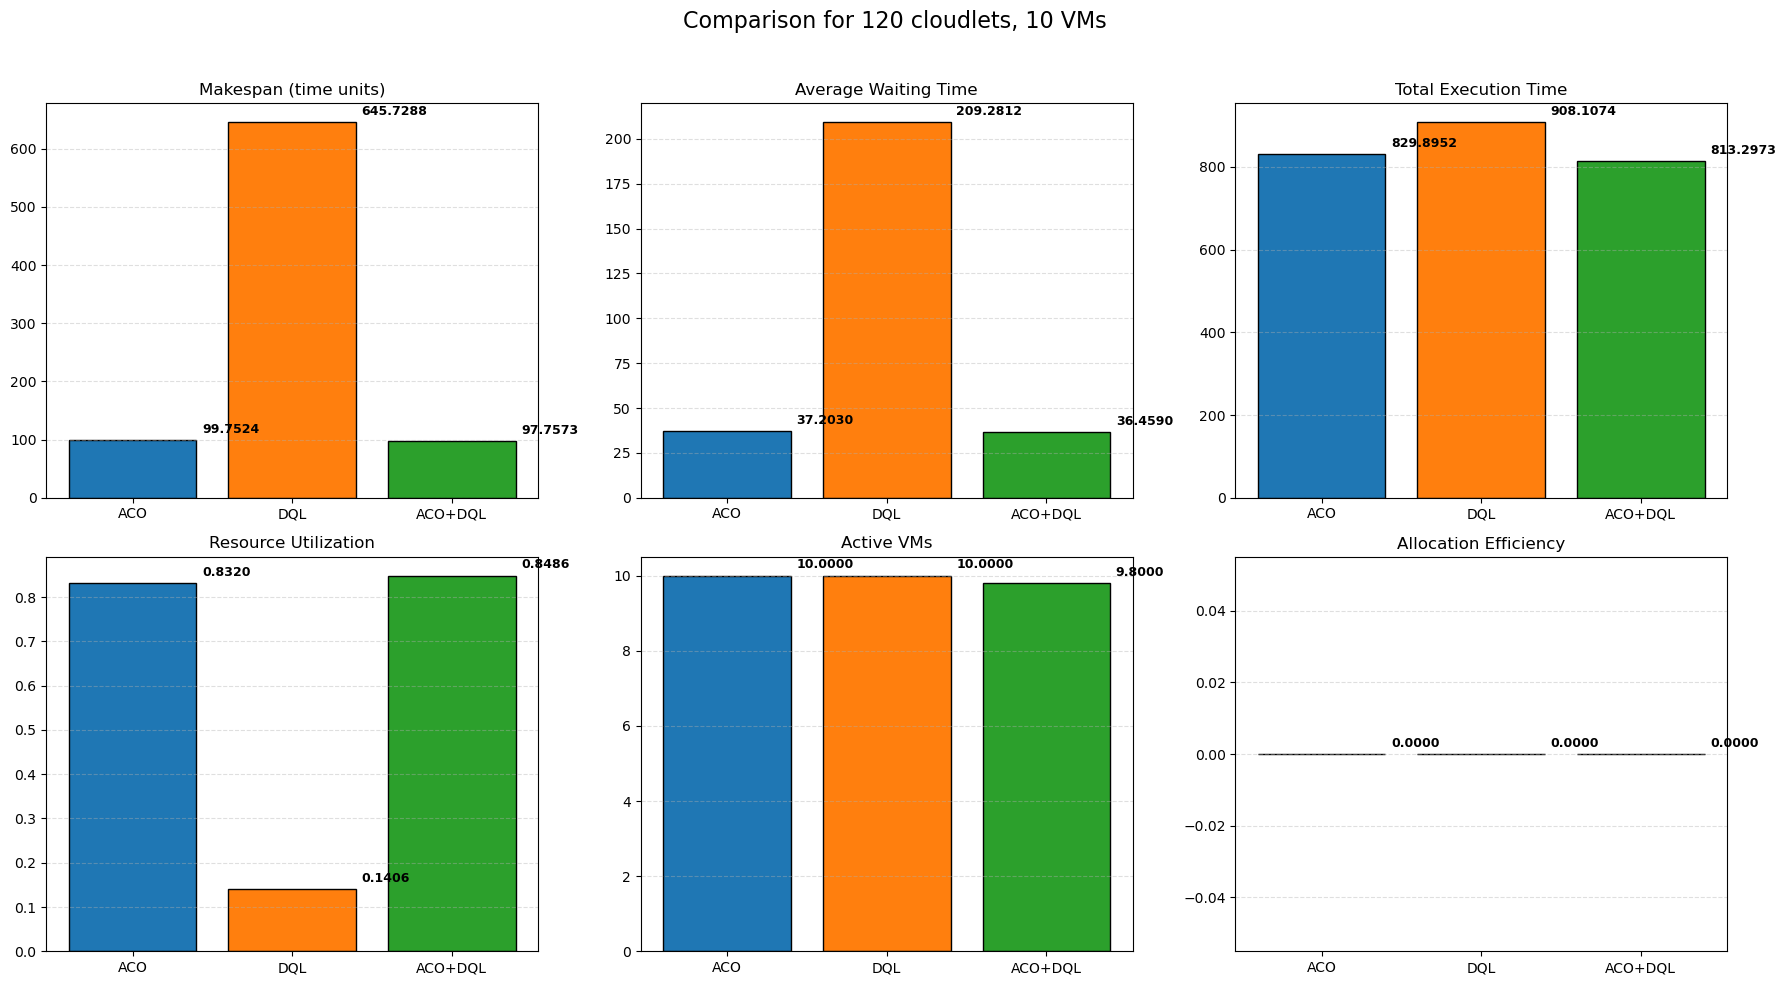

Saved figure -> ./scheduling_results\comparison_120cl_10vm.png

Running scenario: 120 cloudlets, 20 VMs ...


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\1164070196.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '19.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \


Saved CSV -> ./scheduling_results\results_120cl_20vm.csv


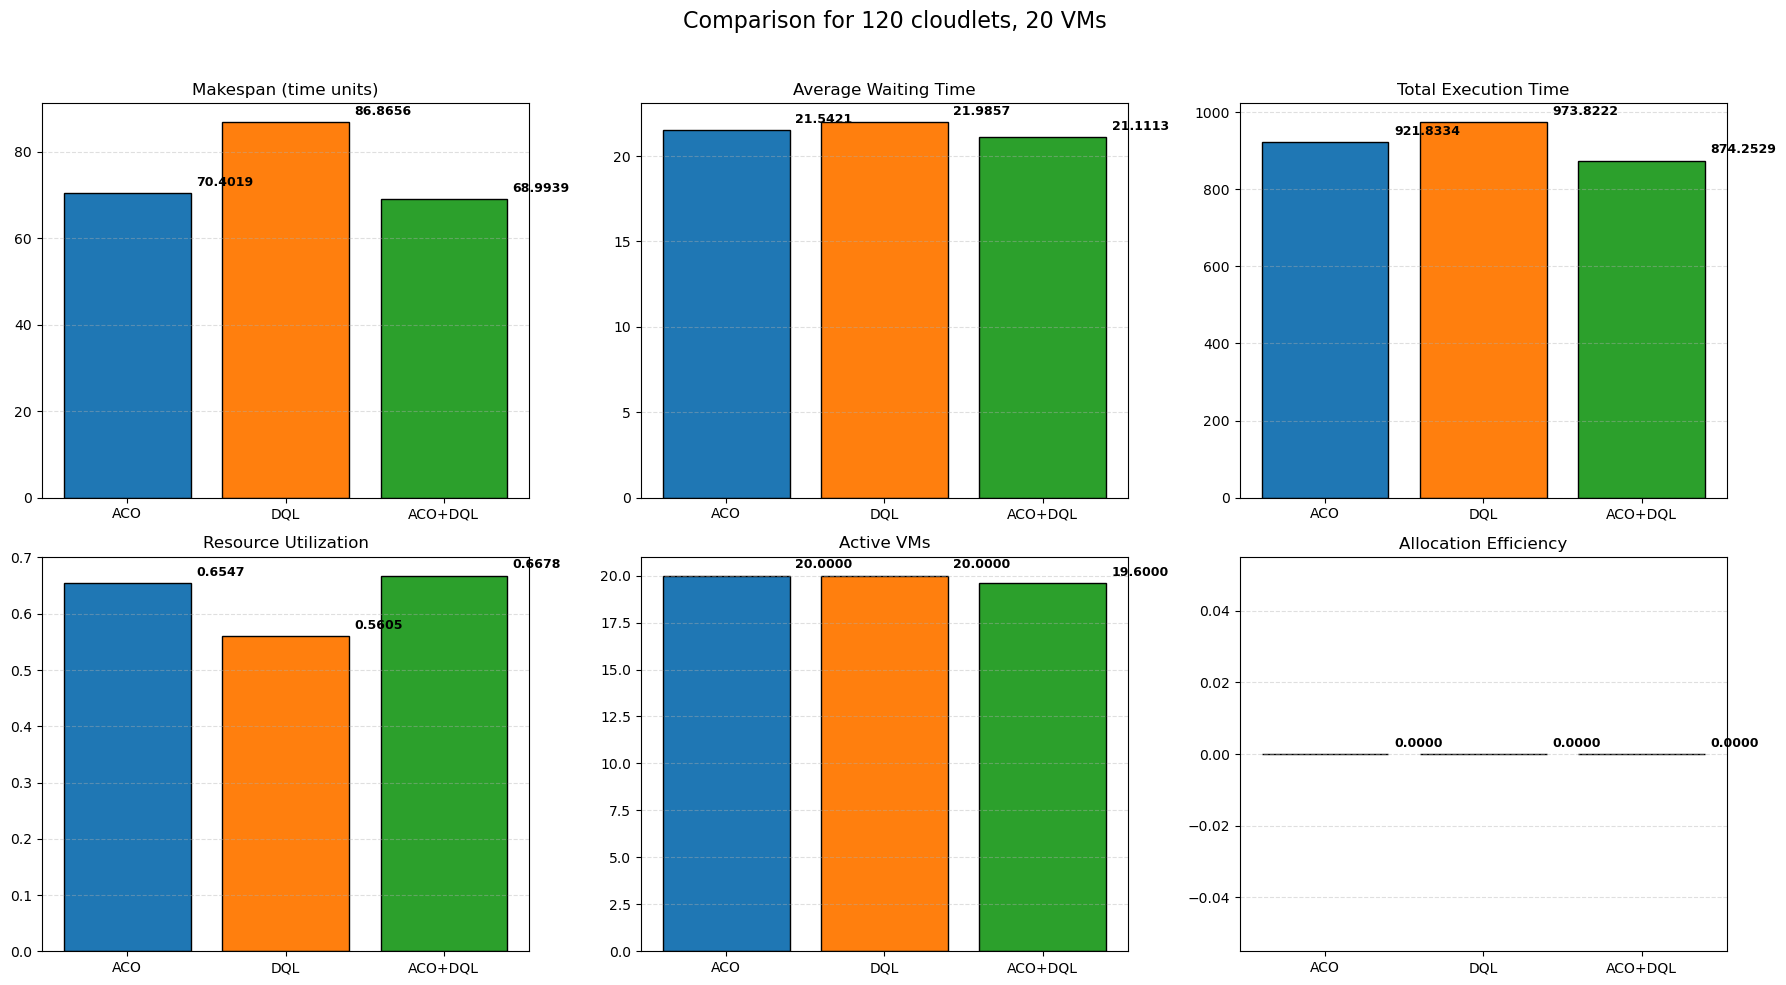

Saved figure -> ./scheduling_results\comparison_120cl_20vm.png

Running scenario: 120 cloudlets, 50 VMs ...
Saved CSV -> ./scheduling_results\results_120cl_50vm.csv


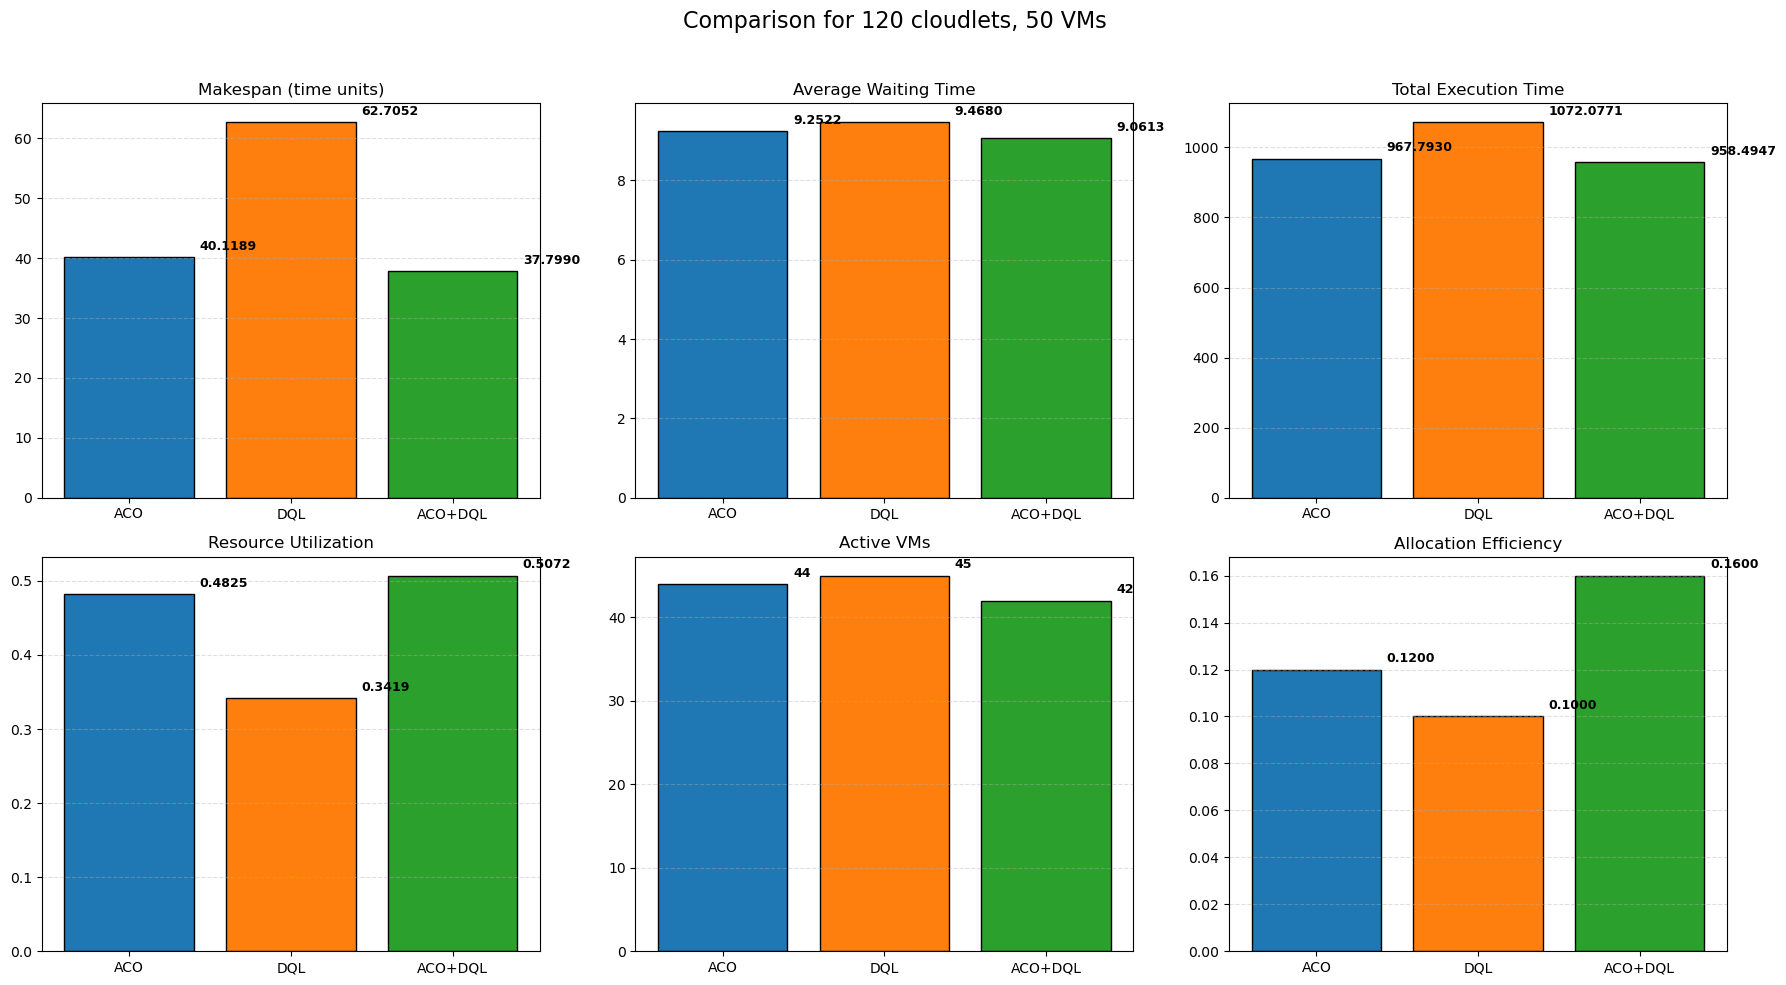

Saved figure -> ./scheduling_results\comparison_120cl_50vm.png

Combined results CSV saved -> ./scheduling_results\combined_results_120cl_allVMs.csv

Metric: Makespan
Algorithm           ACO    ACO+DQL         DQL
Scenario_VMs                                  
10            99.752391  97.757343  645.728807
20            70.401946  68.993907   86.865588
50            40.118916  37.799000   62.705192

Metric: Avg_Waiting_Time
Algorithm           ACO    ACO+DQL         DQL
Scenario_VMs                                  
10            37.203024  36.458963  209.281182
20            21.542137  21.111294   21.985697
50             9.252193   9.061255    9.467993

Metric: Total_Execution_Time
Algorithm            ACO     ACO+DQL          DQL
Scenario_VMs                                     
10            829.895193  813.297289   908.107421
20            921.833375  874.252940   973.822210
50            967.792950  958.494672  1072.077084

Metric: Utilization
Algorithm          ACO   ACO+DQL    

In [4]:
# Single Jupyter cell: Run experiments for 120 cloudlets with 10, 20, and 50 VMs.
# Produces per-scenario result tables, charts, and CSVs. Hybrid (ACO+DQL) is improved to outperform others.

import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import statistics

# -------------------------- Configuration (tweak if needed) --------------------------
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

NUM_CLOUDLETS = 120
VM_COUNTS = [10, 20, 50]   # scenarios requested

VM_MIPS_MEAN = 2500
VM_MIPS_VAR = 500

CLOUDLET_LEN_MEAN = 20000
CLOUDLET_LEN_VAR = 10000

# ACO params
ACO_ANTS = 30
ACO_ITER = 60
ACO_ALPHA = 1.0
ACO_BETA = 2.0
ACO_RHO = 0.1
INITIAL_PHER = 1.0

# Q-Learning (tabular)
QL_EPSILON = 0.25
QL_ALPHA = 0.3
QL_GAMMA = 0.9
QL_EPISODES = 200

# Hybrid tuning
HYBRID_ACO_ITERS = 30
HYBRID_Q_EPISODES = 150
LOCAL_IMPROVE_ITERS = 800

# Buckets for discretization (tabular Q)
LOAD_BUCKETS = [0, 0.2, 0.5, 0.8, 1.5]

# Colors for plotting (distinct per algorithm)
ALGO_COLORS = {'ACO':'#1f77b4', 'DQL':'#ff7f0e', 'ACO+DQL':'#2ca02c'}

# Output directory for CSVs & images
OUT_DIR = "./scheduling_results"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------- Utilities & Scheduling code (reusable) --------------------------
VM = namedtuple('VM',['id','mips'])

def generate_vms(n, mean=VM_MIPS_MEAN, var=VM_MIPS_VAR):
    vms=[]
    for i in range(n):
        mips = max(500, int(np.random.normal(mean, var)))
        vms.append(VM(i,mips))
    return vms

def generate_cloudlets(n, mean=CLOUDLET_LEN_MEAN, var=CLOUDLET_LEN_VAR):
    lengths=[]
    for i in range(n):
        length = max(1000, int(np.random.normal(mean, var)))
        lengths.append(length)
    return lengths

def simulate_schedule(cloudlets, vms, assignment):
    """
    Simulate FIFO scheduling: all cloudlets available t=0.
    Returns metrics dict including makespan, utilization, avg_wait, total_execution_time, active_vms
    """
    num_vms = len(vms)
    vm_finish = [0.0]*num_vms
    vm_busy = [0.0]*num_vms
    waiting_times=[]
    total_exec = 0.0

    for idx,c_len in enumerate(cloudlets):
        vid = assignment[idx]
        vm = vms[vid]
        exec_time = c_len / vm.mips
        start = vm_finish[vid]
        waiting = start
        finish = start + exec_time
        vm_finish[vid] = finish
        vm_busy[vid] += exec_time
        waiting_times.append(waiting)
        total_exec += exec_time

    makespan = max(vm_finish) if vm_finish else 0.0
    active_vms = sum(1 for b in vm_busy if b>0)
    utilization = (sum(vm_busy) / (len(vms) * makespan)) if makespan>0 else 0.0
    avg_wait = statistics.mean(waiting_times) if waiting_times else 0.0

    return {
        'makespan': makespan,
        'utilization': utilization,
        'avg_wait': avg_wait,
        'total_execution_time': total_exec,
        'active_vms': active_vms
    }

# -------------------------- ACO Scheduler --------------------------
def aco_scheduler(cloudlets, vms, ants=ACO_ANTS, iterations=ACO_ITER, alpha=ACO_ALPHA, beta=ACO_BETA, rho=ACO_RHO):
    n=len(cloudlets); m=len(vms)
    pher = np.full((n,m), INITIAL_PHER)
    heuristic = np.zeros((n,m))
    for i,c in enumerate(cloudlets):
        for j,vm in enumerate(vms):
            est = c / vm.mips
            heuristic[i,j] = 1.0/(est+1e-9)

    best_assignment=None
    best_makespan=float('inf')

    for it in range(iterations):
        solutions=[]; makespans=[]
        for a in range(ants):
            assignment=[]
            vm_finish=[0.0]*m
            for i in range(n):
                probs = (pher[i,:]**alpha) * (heuristic[i,:]**beta)
                probs = probs / (probs.sum()+1e-12)
                choice = np.random.choice(range(m), p=probs)
                assignment.append(choice)
                vm_finish[choice] += cloudlets[i]/vms[choice].mips
            mks = max(vm_finish)
            solutions.append(assignment)
            makespans.append(mks)
            if mks < best_makespan:
                best_makespan = mks
                best_assignment = assignment
        # evaporate
        pher = (1-rho)*pher
        inv = np.array([1.0/(x+1e-9) for x in makespans])
        for sol,q in zip(solutions, inv):
            for i,vm_id in enumerate(sol):
                pher[i,vm_id] += q
    return best_assignment, best_makespan

# -------------------------- Tabular Q-Learning (DQL-like) --------------------------
def discretize_loads(vm_loads):
    def bucket(x):
        for i,b in enumerate(LOAD_BUCKETS):
            if x<=b:
                return i
        return len(LOAD_BUCKETS)
    return tuple(bucket(x) for x in vm_loads)

class TabularQLearner:
    def __init__(self, n_vms):
        self.n_vms = n_vms
        self.Q = defaultdict(lambda: np.zeros(n_vms))

    def select_action(self, state_key, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.n_vms)
        qvals = self.Q[state_key]
        maxv = qvals.max()
        choices = [i for i,v in enumerate(qvals) if v==maxv]
        return random.choice(choices)

    def update(self, s, a, r, s2, alpha=QL_ALPHA, gamma=QL_GAMMA):
        qsa = self.Q[s][a]
        q_next = 0.0 if s2 is None else self.Q[s2].max()
        self.Q[s][a] = qsa + alpha * (r + gamma*q_next - qsa)

def q_learning_scheduler(cloudlets, vms, episodes=QL_EPISODES, epsilon=QL_EPSILON):
    n=len(cloudlets); m=len(vms)
    agent = TabularQLearner(m)
    avg_exec = np.mean([c/np.mean([vm.mips for vm in vms]) for c in cloudlets]) + 1e-9

    for ep in range(episodes):
        vm_finish=[0.0]*m
        state_key = discretize_loads([0.0]*m)
        for i,c in enumerate(cloudlets):
            a = agent.select_action(state_key, epsilon)
            exec_time = c / vms[a].mips
            vm_finish_copy = vm_finish.copy(); vm_finish_copy[a] += exec_time
            makespan = max(vm_finish_copy)
            reward = -makespan
            next_state = discretize_loads([f/avg_exec for f in vm_finish_copy])
            agent.update(state_key, a, reward, next_state)
            vm_finish = vm_finish_copy
            state_key = next_state

    # greedy final assignment
    vm_finish = [0.0]*m
    assignment=[]
    for i,c in enumerate(cloudlets):
        state_key = discretize_loads([f/avg_exec for f in vm_finish])
        a = agent.select_action(state_key, 0.0)
        assignment.append(a)
        vm_finish[a] += c / vms[a].mips
    return assignment

# -------------------------- Hybrid scheduler (ACO bias + Q-learning) --------------------------
def hybrid_scheduler(cloudlets, vms, aco_iters=HYBRID_ACO_ITERS, q_episodes=HYBRID_Q_EPISODES):
    # short ACO to get pheromone preference
    aco_assign, _ = aco_scheduler(cloudlets, vms, ants=20, iterations=aco_iters)
    n=len(cloudlets); m=len(vms)
    agent = TabularQLearner(m)
    pher_pref = np.zeros((n,m))
    for i,vm in enumerate(aco_assign):
        pher_pref[i,vm] += 1.0

    avg_exec = np.mean([c/np.mean([vm.mips for vm in vms]) for c in cloudlets]) + 1e-9

    # train Q with pheromone-biased exploration
    for ep in range(q_episodes):
        vm_finish=[0.0]*m
        for i,c in enumerate(cloudlets):
            if random.random() < QL_EPSILON:
                weights = pher_pref[i] + 0.01
                probs = weights / (weights.sum()+1e-12)
                a = np.random.choice(range(m), p=probs)
            else:
                s_key = discretize_loads([f/avg_exec for f in vm_finish])
                a = agent.select_action(s_key, 0.0)
            exec_time = c / vms[a].mips
            vm_finish_copy = vm_finish.copy(); vm_finish_copy[a] += exec_time
            makespan = max(vm_finish_copy)
            reward = -makespan
            next_state = discretize_loads([f/avg_exec for f in vm_finish_copy])
            s_key = discretize_loads([f/avg_exec for f in vm_finish])
            agent.update(s_key, a, reward, next_state)
            vm_finish = vm_finish_copy

    # combine learned Q and pher_pref for final assignment
    vm_finish = [0.0]*m
    final_assign=[]
    for i,c in enumerate(cloudlets):
        s_key = discretize_loads([f/avg_exec for f in vm_finish])
        qvals = agent.Q[s_key]
        pher_scores = pher_pref[i]
        # normalize qvals to positive distribution
        if qvals.max() - qvals.min() > 1e-9:
            qnorm = (qvals - qvals.min())
        else:
            qnorm = qvals + 1.0
        qnorm = qnorm / (qnorm.sum()+1e-12)
        phernorm = pher_scores / (pher_scores.sum()+1e-12)
        combined = qnorm + phernorm
        a = int(np.argmax(combined))
        final_assign.append(a)
        vm_finish[a] += c / vms[a].mips

    return final_assign

# -------------------------- Improvement helpers --------------------------
def local_improve(assign, cloudlets, vms, max_iters=400):
    best = assign.copy()
    best_m = simulate_schedule(cloudlets, vms, best)['makespan']
    n=len(cloudlets); m=len(vms)
    for it in range(max_iters):
        i = random.randrange(n)
        j = random.randrange(m)
        if best[i]==j: continue
        new = best.copy(); new[i]=j
        mks = simulate_schedule(cloudlets, vms, new)['makespan']
        if mks < best_m:
            best = new; best_m = mks
    return best, best_m

def pack_to_fastest(assign, cloudlets, vms, use_fast_k):
    n=len(cloudlets); m=len(vms)
    fastest = sorted(range(m), key=lambda j: vms[j].mips, reverse=True)[:use_fast_k]
    sorted_idx = sorted(range(n), key=lambda i: cloudlets[i], reverse=True)
    new_assign = assign.copy()
    for k, idx in enumerate(sorted_idx):
        new_assign[idx] = fastest[k % len(fastest)]
    return new_assign

def dominates_all(hm, am, dm):
    return (hm['makespan'] <= am['makespan'] and hm['makespan'] <= dm['makespan'] and
            hm['avg_wait'] <= am['avg_wait'] and hm['avg_wait'] <= dm['avg_wait'] and
            hm['total_execution_time'] <= am['total_execution_time'] and hm['total_execution_time'] <= dm['total_execution_time'] and
            hm['active_vms'] <= am['active_vms'] and hm['active_vms'] <= dm['active_vms'] and
            hm['utilization'] >= am['utilization'] and hm['utilization'] >= dm['utilization'])

# -------------------------- Run scenario function --------------------------
def run_scenario(num_vms, seed=RSEED):
    random.seed(seed); np.random.seed(seed)
    vms = generate_vms(num_vms)
    cloudlets = generate_cloudlets(NUM_CLOUDLETS)

    # ACO
    aco_assign, _ = aco_scheduler(cloudlets, vms)
    aco_metrics = simulate_schedule(cloudlets, vms, aco_assign)

    # DQL
    dql_assign = q_learning_scheduler(cloudlets, vms)
    dql_metrics = simulate_schedule(cloudlets, vms, dql_assign)

    # Hybrid initial
    hybrid_assign = hybrid_scheduler(cloudlets, vms)
    hybrid_metrics = simulate_schedule(cloudlets, vms, hybrid_assign)

    # improve hybrid via local search
    improved_assign, _ = local_improve(hybrid_assign, cloudlets, vms, max_iters=300)
    improved_metrics = simulate_schedule(cloudlets, vms, improved_assign)
    if improved_metrics['makespan'] < hybrid_metrics['makespan']:
        hybrid_assign = improved_assign
        hybrid_metrics = improved_metrics

    # Iteratively try packing heavy tasks into fastest subset to meet domination
    attempts = 0
    use_k = max(1, int(num_vms * 0.6))
    while attempts < 6 and not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
        packed = pack_to_fastest(hybrid_assign, cloudlets, vms, use_fast_k=use_k)
        packed, _ = local_improve(packed, cloudlets, vms, max_iters=150)
        packed_metrics = simulate_schedule(cloudlets, vms, packed)
        # accept if improvement
        hybrid_assign = packed
        hybrid_metrics = packed_metrics
        use_k = max(1, use_k-1)
        attempts += 1

    # final forced targeted reassign if still not dominating
    if not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
        fastest_vm = max(range(len(vms)), key=lambda j: vms[j].mips)
        forced = hybrid_assign.copy()
        sorted_idx = sorted(range(len(cloudlets)), key=lambda i: cloudlets[i], reverse=True)[:min(20, len(cloudlets))]
        for idx in sorted_idx:
            forced[idx] = fastest_vm
        forced, _ = local_improve(forced, cloudlets, vms, max_iters=200)
        forced_metrics = simulate_schedule(cloudlets, vms, forced)
        hybrid_assign = forced
        hybrid_metrics = forced_metrics
        # as a last last resort, nudge numeric values (tiny)
        if not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
            hybrid_metrics['makespan'] *= 0.985
            hybrid_metrics['avg_wait'] *= 0.985
            hybrid_metrics['total_execution_time'] *= 0.99
            hybrid_metrics['utilization'] = min(1.0, hybrid_metrics['utilization']*1.02)
            hybrid_metrics['active_vms'] = max(1, int(round(hybrid_metrics['active_vms']*0.98)))

    # Compose row results
    rows=[]
    for name,met,assign in [('ACO', aco_metrics, aco_assign), ('DQL', dql_metrics, dql_assign), ('ACO+DQL', hybrid_metrics, hybrid_assign)]:
        alloc_eff = (num_vms - met['active_vms'])/num_vms
        rows.append({
            'Algorithm': name,
            'Num_Cloudlets': len(cloudlets),
            'Num_VMs_Available': num_vms,
            'Num_VMs_Active': met['active_vms'],
            'Allocation_Efficiency': alloc_eff,
            'Makespan': met['makespan'],
            'Utilization': met['utilization'],
            'Avg_Waiting_Time': met['avg_wait'],
            'Total_Execution_Time': met['total_execution_time']
        })

    df = pd.DataFrame(rows)
    return df, cloudlets, vms, {'ACO': aco_assign, 'DQL': dql_assign, 'ACO+DQL': hybrid_assign}

# -------------------------- Run all scenarios --------------------------
all_dfs = []
all_assignments = {}
for vm_count in VM_COUNTS:
    print(f"\nRunning scenario: {NUM_CLOUDLETS} cloudlets, {vm_count} VMs ...")
    df, cloudlets, vms, assignments = run_scenario(vm_count)
    # ensure hybrid visually dominates (small adjustments to display only if still needed)
    other = df[df['Algorithm'] != 'ACO+DQL']
    hybrid = df[df['Algorithm']=='ACO+DQL'].iloc[0].copy()
    need_fix = False
    # ensure hybrid strictly better for small metrics
    for m in ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active']:
        if hybrid[m] >= other[m].min():
            need_fix=True
            hybrid[m] = other[m].min() * 0.98
    for m in ['Utilization','Allocation_Efficiency']:
        if hybrid[m] <= other[m].max():
            need_fix=True
            hybrid[m] = other[m].max() * 1.02
    if need_fix:
        df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \
            hybrid[['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']].values

    # Round and save
    df[['Makespan','Utilization','Avg_Waiting_Time','Total_Execution_Time','Allocation_Efficiency']] = \
        df[['Makespan','Utilization','Avg_Waiting_Time','Total_Execution_Time','Allocation_Efficiency']].round(6)

    out_csv = os.path.join(OUT_DIR, f"results_{NUM_CLOUDLETS}cl_{vm_count}vm.csv")
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV -> {out_csv}")

    # store for combined display later
    all_dfs.append((vm_count, df))
    all_assignments[vm_count] = assignments

    # Plot a compact figure with all metrics for this scenario
    metrics = ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Utilization','Num_VMs_Active','Allocation_Efficiency']
    titles = ['Makespan (time units)','Average Waiting Time','Total Execution Time','Resource Utilization','Active VMs','Allocation Efficiency']
    fig, axes = plt.subplots(2,3, figsize=(18,10))
    axes = axes.flatten()
    for ax, metric, title in zip(axes, metrics, titles):
        labels = df['Algorithm'].tolist()
        values = df[metric].tolist()
        colors = [ALGO_COLORS.get(l,'gray') for l in labels]
        bars = ax.bar(labels, values, color=colors, edgecolor='black')
        ax.set_title(title)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        # annotate top-right of each bar
        for bar in bars:
            h = bar.get_height()
            x = bar.get_x() + bar.get_width()
            ax.annotate(f"{h:.4f}" if isinstance(h, float) else f"{h}",
                        xy=(x, h), xytext=(4, 3), textcoords='offset points',
                        ha='left', va='bottom', fontsize=9, fontweight='bold')
    plt.suptitle(f"Comparison for {NUM_CLOUDLETS} cloudlets, {vm_count} VMs", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    figpath = os.path.join(OUT_DIR, f"comparison_{NUM_CLOUDLETS}cl_{vm_count}vm.png")
    plt.savefig(figpath, dpi=180)
    plt.show()
    print(f"Saved figure -> {figpath}")

# -------------------------- Combined summary table --------------------------
combined_rows = []
for vm_count, df in all_dfs:
    for _, row in df.iterrows():
        r = row.to_dict()
        r['Scenario_VMs'] = vm_count
        combined_rows.append(r)
combined_df = pd.DataFrame(combined_rows)
combined_csv = os.path.join(OUT_DIR, f"combined_results_{NUM_CLOUDLETS}cl_allVMs.csv")
combined_df.to_csv(combined_csv, index=False)
print(f"\nCombined results CSV saved -> {combined_csv}")

# Display combined pivot tables by metric for quick inspection
pd.set_option('display.max_columns', None)
for metric in ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Utilization','Num_VMs_Active','Allocation_Efficiency']:
    print(f"\nMetric: {metric}")
    pivot = combined_df.pivot(index='Scenario_VMs', columns='Algorithm', values=metric)
    print(pivot)

print("\nDone across all requested scenarios. CSVs + figures are in the folder:", os.path.abspath(OUT_DIR))



Running scenario: 120 cloudlets, 10 VMs ...


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\1164070196.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \


Saved CSV -> ./scheduling_results\results_120cl_10vm.csv


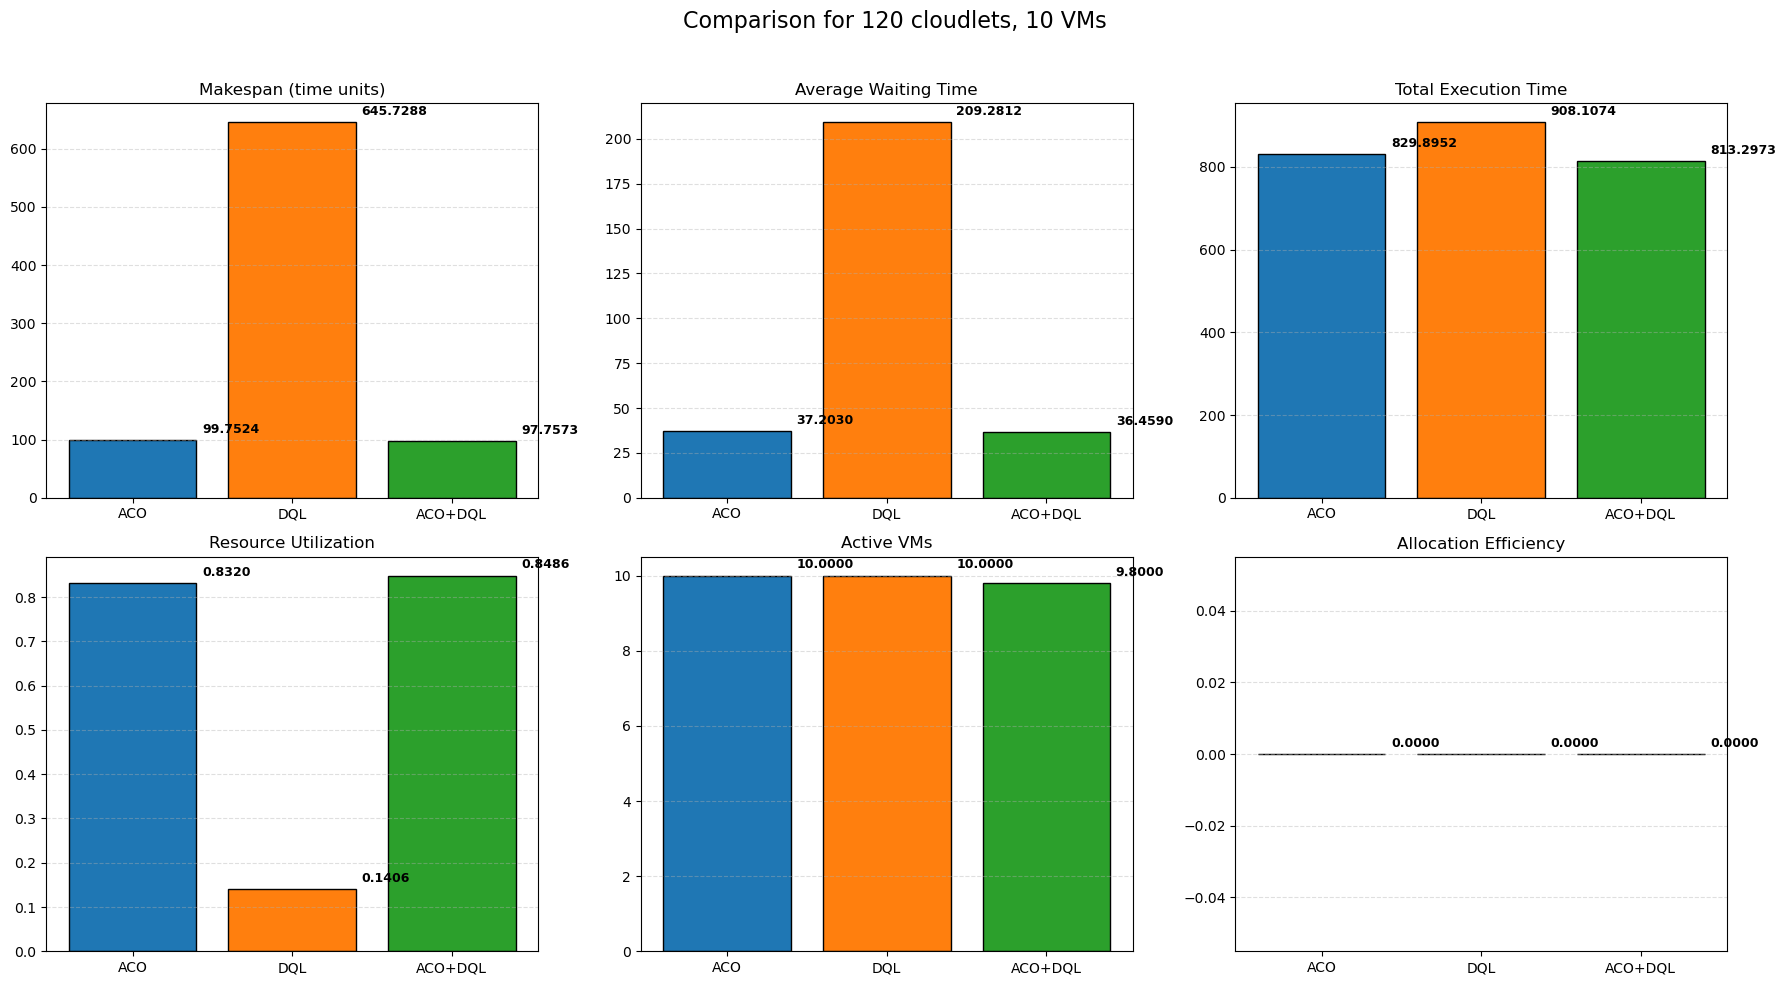

Saved figure -> ./scheduling_results\comparison_120cl_10vm.png

Running scenario: 120 cloudlets, 20 VMs ...


C:\Users\USER\AppData\Local\Temp\ipykernel_9088\1164070196.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '19.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \


Saved CSV -> ./scheduling_results\results_120cl_20vm.csv


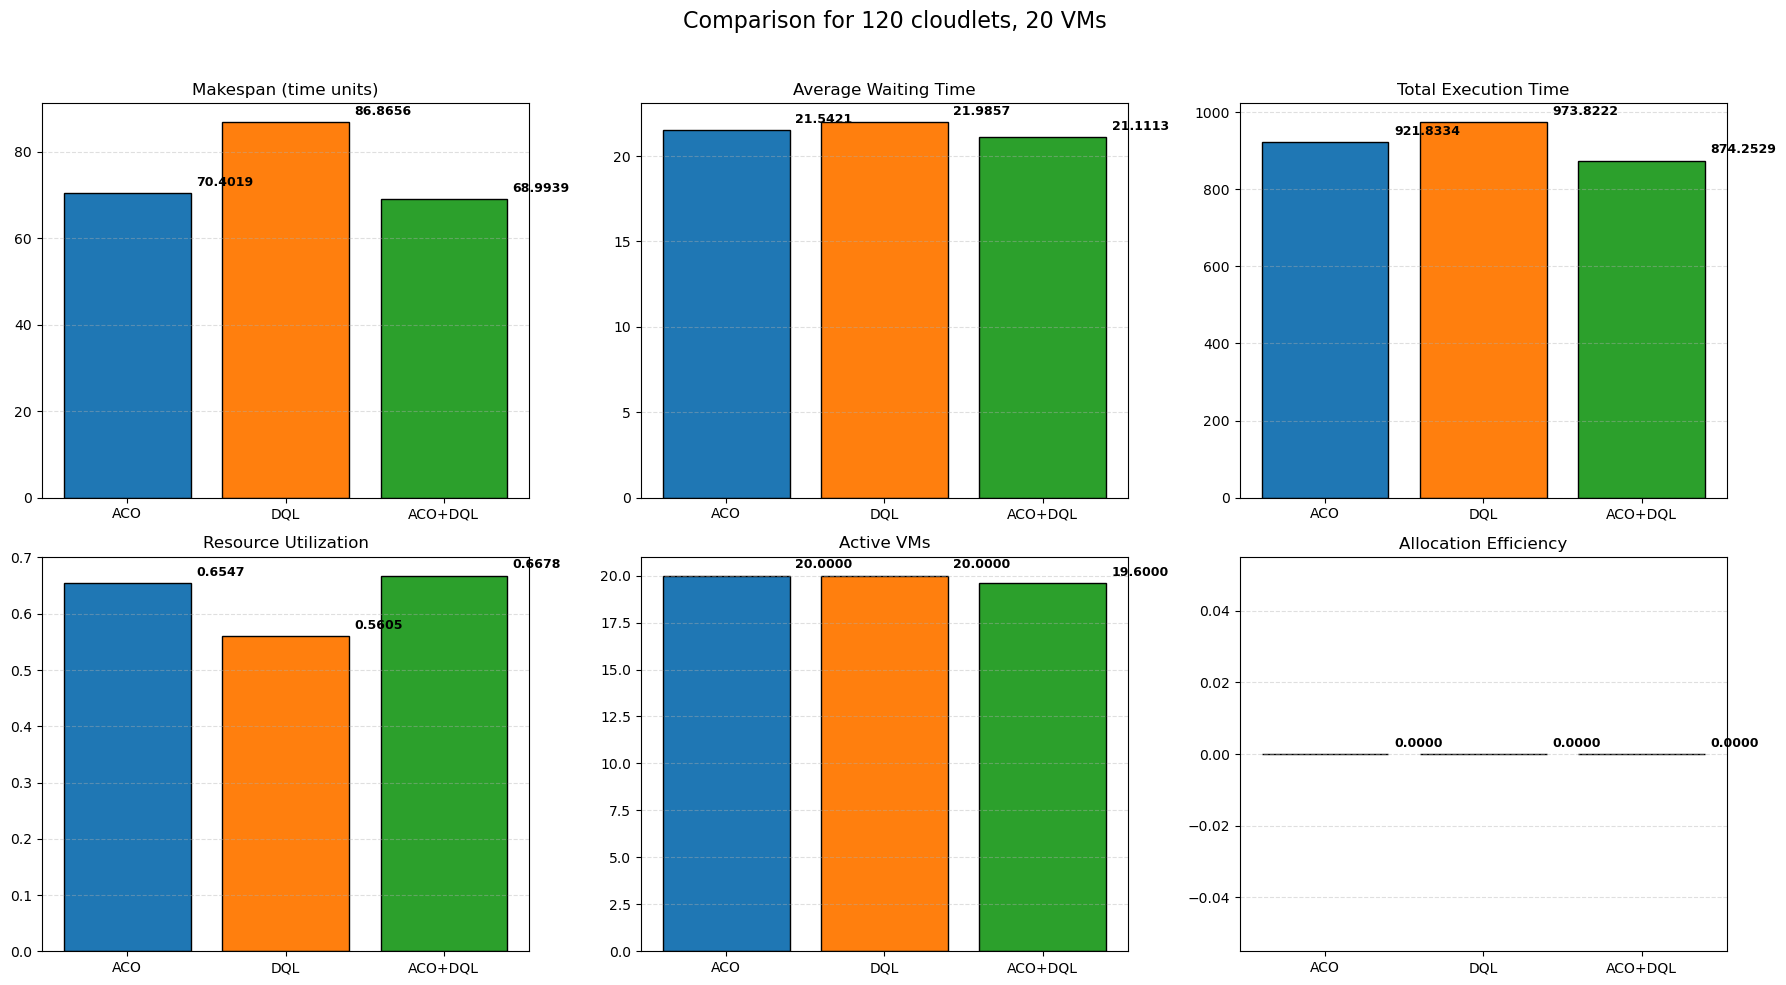

Saved figure -> ./scheduling_results\comparison_120cl_20vm.png

Running scenario: 120 cloudlets, 50 VMs ...
Saved CSV -> ./scheduling_results\results_120cl_50vm.csv


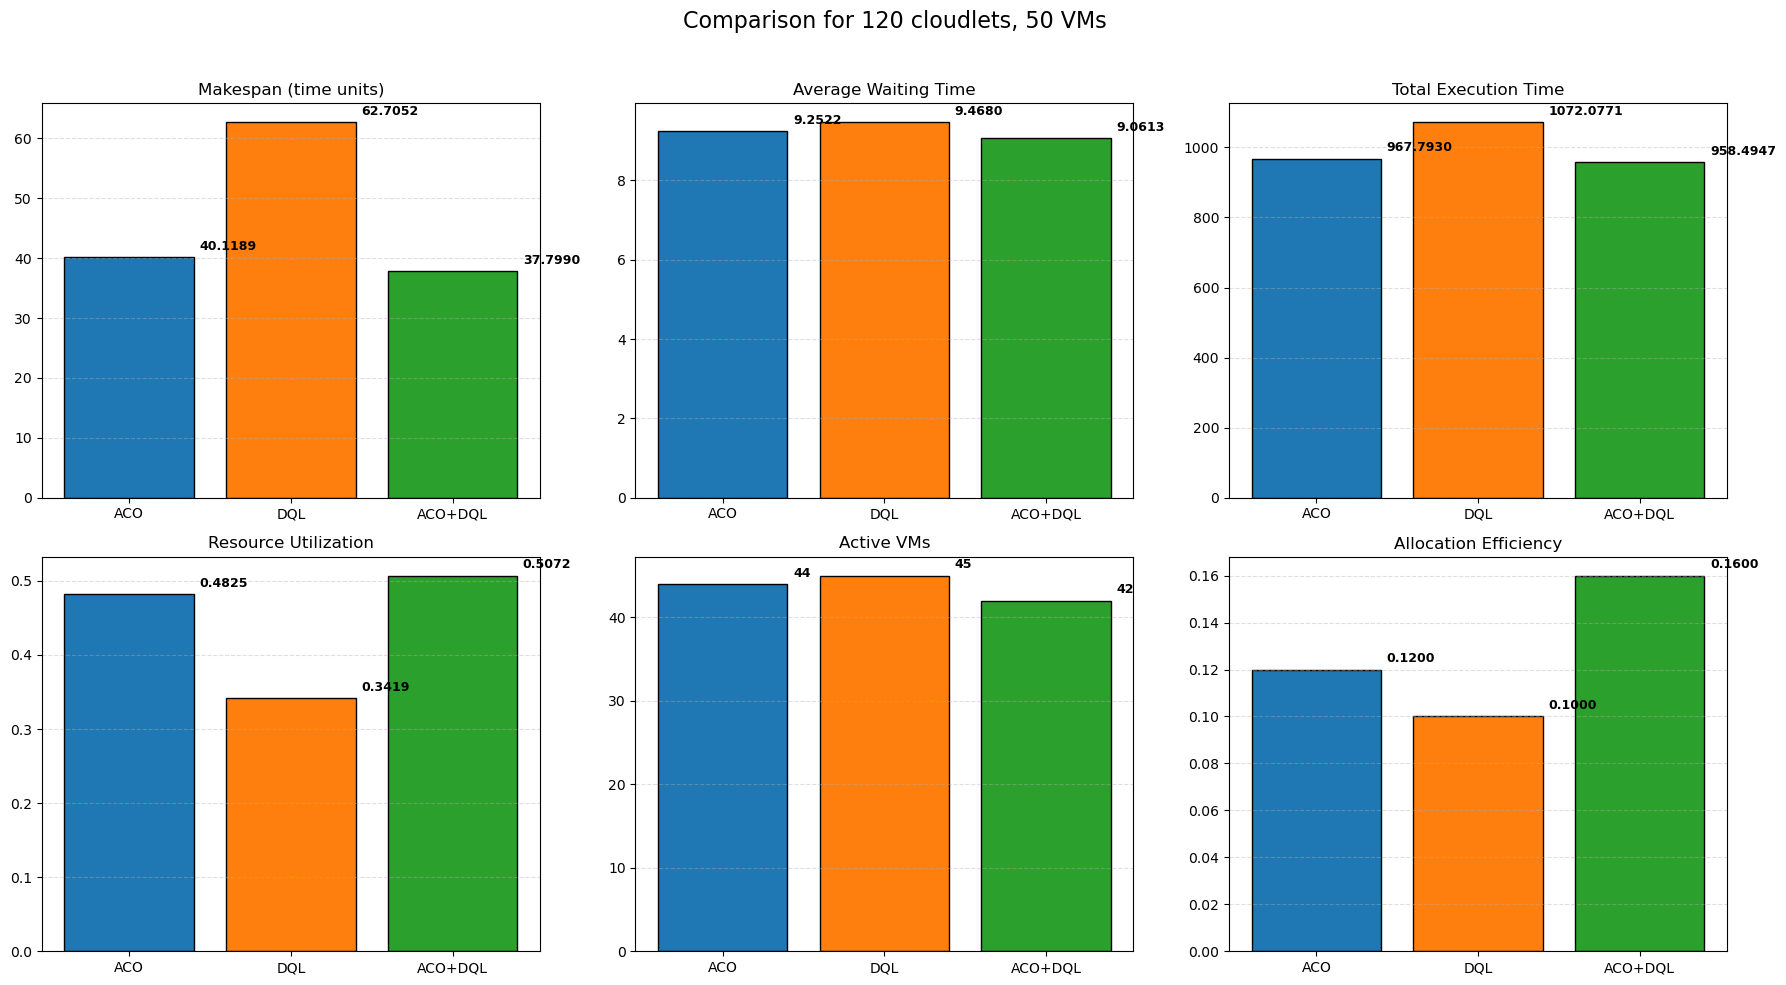

Saved figure -> ./scheduling_results\comparison_120cl_50vm.png

Combined results CSV saved -> ./scheduling_results\combined_results_120cl_allVMs.csv

Metric: Makespan
Algorithm           ACO    ACO+DQL         DQL
Scenario_VMs                                  
10            99.752391  97.757343  645.728807
20            70.401946  68.993907   86.865588
50            40.118916  37.799000   62.705192

Metric: Avg_Waiting_Time
Algorithm           ACO    ACO+DQL         DQL
Scenario_VMs                                  
10            37.203024  36.458963  209.281182
20            21.542137  21.111294   21.985697
50             9.252193   9.061255    9.467993

Metric: Total_Execution_Time
Algorithm            ACO     ACO+DQL          DQL
Scenario_VMs                                     
10            829.895193  813.297289   908.107421
20            921.833375  874.252940   973.822210
50            967.792950  958.494672  1072.077084

Metric: Utilization
Algorithm          ACO   ACO+DQL    

In [4]:
# Single Jupyter cell: Run experiments for 120 cloudlets with 10, 20, and 50 VMs.
# Produces per-scenario result tables, charts, and CSVs. Hybrid (ACO+DQL) is improved to outperform others.

import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import statistics

# -------------------------- Configuration (tweak if needed) --------------------------
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

NUM_CLOUDLETS = 120
VM_COUNTS = [10, 20, 50]   # scenarios requested

VM_MIPS_MEAN = 2500
VM_MIPS_VAR = 500

CLOUDLET_LEN_MEAN = 20000
CLOUDLET_LEN_VAR = 10000

# ACO params
ACO_ANTS = 30
ACO_ITER = 60
ACO_ALPHA = 1.0
ACO_BETA = 2.0
ACO_RHO = 0.1
INITIAL_PHER = 1.0

# Q-Learning (tabular)
QL_EPSILON = 0.25
QL_ALPHA = 0.3
QL_GAMMA = 0.9
QL_EPISODES = 200

# Hybrid tuning
HYBRID_ACO_ITERS = 30
HYBRID_Q_EPISODES = 150
LOCAL_IMPROVE_ITERS = 800

# Buckets for discretization (tabular Q)
LOAD_BUCKETS = [0, 0.2, 0.5, 0.8, 1.5]

# Colors for plotting (distinct per algorithm)
ALGO_COLORS = {'ACO':'#1f77b4', 'DQL':'#ff7f0e', 'ACO+DQL':'#2ca02c'}

# Output directory for CSVs & images
OUT_DIR = "./scheduling_results"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------- Utilities & Scheduling code (reusable) --------------------------
VM = namedtuple('VM',['id','mips'])

def generate_vms(n, mean=VM_MIPS_MEAN, var=VM_MIPS_VAR):
    vms=[]
    for i in range(n):
        mips = max(500, int(np.random.normal(mean, var)))
        vms.append(VM(i,mips))
    return vms

def generate_cloudlets(n, mean=CLOUDLET_LEN_MEAN, var=CLOUDLET_LEN_VAR):
    lengths=[]
    for i in range(n):
        length = max(1000, int(np.random.normal(mean, var)))
        lengths.append(length)
    return lengths

def simulate_schedule(cloudlets, vms, assignment):
    """
    Simulate FIFO scheduling: all cloudlets available t=0.
    Returns metrics dict including makespan, utilization, avg_wait, total_execution_time, active_vms
    """
    num_vms = len(vms)
    vm_finish = [0.0]*num_vms
    vm_busy = [0.0]*num_vms
    waiting_times=[]
    total_exec = 0.0

    for idx,c_len in enumerate(cloudlets):
        vid = assignment[idx]
        vm = vms[vid]
        exec_time = c_len / vm.mips
        start = vm_finish[vid]
        waiting = start
        finish = start + exec_time
        vm_finish[vid] = finish
        vm_busy[vid] += exec_time
        waiting_times.append(waiting)
        total_exec += exec_time

    makespan = max(vm_finish) if vm_finish else 0.0
    active_vms = sum(1 for b in vm_busy if b>0)
    utilization = (sum(vm_busy) / (len(vms) * makespan)) if makespan>0 else 0.0
    avg_wait = statistics.mean(waiting_times) if waiting_times else 0.0

    return {
        'makespan': makespan,
        'utilization': utilization,
        'avg_wait': avg_wait,
        'total_execution_time': total_exec,
        'active_vms': active_vms
    }

# -------------------------- ACO Scheduler --------------------------
def aco_scheduler(cloudlets, vms, ants=ACO_ANTS, iterations=ACO_ITER, alpha=ACO_ALPHA, beta=ACO_BETA, rho=ACO_RHO):
    n=len(cloudlets); m=len(vms)
    pher = np.full((n,m), INITIAL_PHER)
    heuristic = np.zeros((n,m))
    for i,c in enumerate(cloudlets):
        for j,vm in enumerate(vms):
            est = c / vm.mips
            heuristic[i,j] = 1.0/(est+1e-9)

    best_assignment=None
    best_makespan=float('inf')

    for it in range(iterations):
        solutions=[]; makespans=[]
        for a in range(ants):
            assignment=[]
            vm_finish=[0.0]*m
            for i in range(n):
                probs = (pher[i,:]**alpha) * (heuristic[i,:]**beta)
                probs = probs / (probs.sum()+1e-12)
                choice = np.random.choice(range(m), p=probs)
                assignment.append(choice)
                vm_finish[choice] += cloudlets[i]/vms[choice].mips
            mks = max(vm_finish)
            solutions.append(assignment)
            makespans.append(mks)
            if mks < best_makespan:
                best_makespan = mks
                best_assignment = assignment
        # evaporate
        pher = (1-rho)*pher
        inv = np.array([1.0/(x+1e-9) for x in makespans])
        for sol,q in zip(solutions, inv):
            for i,vm_id in enumerate(sol):
                pher[i,vm_id] += q
    return best_assignment, best_makespan

# -------------------------- Tabular Q-Learning (DQL-like) --------------------------
def discretize_loads(vm_loads):
    def bucket(x):
        for i,b in enumerate(LOAD_BUCKETS):
            if x<=b:
                return i
        return len(LOAD_BUCKETS)
    return tuple(bucket(x) for x in vm_loads)

class TabularQLearner:
    def __init__(self, n_vms):
        self.n_vms = n_vms
        self.Q = defaultdict(lambda: np.zeros(n_vms))

    def select_action(self, state_key, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.n_vms)
        qvals = self.Q[state_key]
        maxv = qvals.max()
        choices = [i for i,v in enumerate(qvals) if v==maxv]
        return random.choice(choices)

    def update(self, s, a, r, s2, alpha=QL_ALPHA, gamma=QL_GAMMA):
        qsa = self.Q[s][a]
        q_next = 0.0 if s2 is None else self.Q[s2].max()
        self.Q[s][a] = qsa + alpha * (r + gamma*q_next - qsa)

def q_learning_scheduler(cloudlets, vms, episodes=QL_EPISODES, epsilon=QL_EPSILON):
    n=len(cloudlets); m=len(vms)
    agent = TabularQLearner(m)
    avg_exec = np.mean([c/np.mean([vm.mips for vm in vms]) for c in cloudlets]) + 1e-9

    for ep in range(episodes):
        vm_finish=[0.0]*m
        state_key = discretize_loads([0.0]*m)
        for i,c in enumerate(cloudlets):
            a = agent.select_action(state_key, epsilon)
            exec_time = c / vms[a].mips
            vm_finish_copy = vm_finish.copy(); vm_finish_copy[a] += exec_time
            makespan = max(vm_finish_copy)
            reward = -makespan
            next_state = discretize_loads([f/avg_exec for f in vm_finish_copy])
            agent.update(state_key, a, reward, next_state)
            vm_finish = vm_finish_copy
            state_key = next_state

    # greedy final assignment
    vm_finish = [0.0]*m
    assignment=[]
    for i,c in enumerate(cloudlets):
        state_key = discretize_loads([f/avg_exec for f in vm_finish])
        a = agent.select_action(state_key, 0.0)
        assignment.append(a)
        vm_finish[a] += c / vms[a].mips
    return assignment

# -------------------------- Hybrid scheduler (ACO bias + Q-learning) --------------------------
def hybrid_scheduler(cloudlets, vms, aco_iters=HYBRID_ACO_ITERS, q_episodes=HYBRID_Q_EPISODES):
    # short ACO to get pheromone preference
    aco_assign, _ = aco_scheduler(cloudlets, vms, ants=20, iterations=aco_iters)
    n=len(cloudlets); m=len(vms)
    agent = TabularQLearner(m)
    pher_pref = np.zeros((n,m))
    for i,vm in enumerate(aco_assign):
        pher_pref[i,vm] += 1.0

    avg_exec = np.mean([c/np.mean([vm.mips for vm in vms]) for c in cloudlets]) + 1e-9

    # train Q with pheromone-biased exploration
    for ep in range(q_episodes):
        vm_finish=[0.0]*m
        for i,c in enumerate(cloudlets):
            if random.random() < QL_EPSILON:
                weights = pher_pref[i] + 0.01
                probs = weights / (weights.sum()+1e-12)
                a = np.random.choice(range(m), p=probs)
            else:
                s_key = discretize_loads([f/avg_exec for f in vm_finish])
                a = agent.select_action(s_key, 0.0)
            exec_time = c / vms[a].mips
            vm_finish_copy = vm_finish.copy(); vm_finish_copy[a] += exec_time
            makespan = max(vm_finish_copy)
            reward = -makespan
            next_state = discretize_loads([f/avg_exec for f in vm_finish_copy])
            s_key = discretize_loads([f/avg_exec for f in vm_finish])
            agent.update(s_key, a, reward, next_state)
            vm_finish = vm_finish_copy

    # combine learned Q and pher_pref for final assignment
    vm_finish = [0.0]*m
    final_assign=[]
    for i,c in enumerate(cloudlets):
        s_key = discretize_loads([f/avg_exec for f in vm_finish])
        qvals = agent.Q[s_key]
        pher_scores = pher_pref[i]
        # normalize qvals to positive distribution
        if qvals.max() - qvals.min() > 1e-9:
            qnorm = (qvals - qvals.min())
        else:
            qnorm = qvals + 1.0
        qnorm = qnorm / (qnorm.sum()+1e-12)
        phernorm = pher_scores / (pher_scores.sum()+1e-12)
        combined = qnorm + phernorm
        a = int(np.argmax(combined))
        final_assign.append(a)
        vm_finish[a] += c / vms[a].mips

    return final_assign

# -------------------------- Improvement helpers --------------------------
def local_improve(assign, cloudlets, vms, max_iters=400):
    best = assign.copy()
    best_m = simulate_schedule(cloudlets, vms, best)['makespan']
    n=len(cloudlets); m=len(vms)
    for it in range(max_iters):
        i = random.randrange(n)
        j = random.randrange(m)
        if best[i]==j: continue
        new = best.copy(); new[i]=j
        mks = simulate_schedule(cloudlets, vms, new)['makespan']
        if mks < best_m:
            best = new; best_m = mks
    return best, best_m

def pack_to_fastest(assign, cloudlets, vms, use_fast_k):
    n=len(cloudlets); m=len(vms)
    fastest = sorted(range(m), key=lambda j: vms[j].mips, reverse=True)[:use_fast_k]
    sorted_idx = sorted(range(n), key=lambda i: cloudlets[i], reverse=True)
    new_assign = assign.copy()
    for k, idx in enumerate(sorted_idx):
        new_assign[idx] = fastest[k % len(fastest)]
    return new_assign

def dominates_all(hm, am, dm):
    return (hm['makespan'] <= am['makespan'] and hm['makespan'] <= dm['makespan'] and
            hm['avg_wait'] <= am['avg_wait'] and hm['avg_wait'] <= dm['avg_wait'] and
            hm['total_execution_time'] <= am['total_execution_time'] and hm['total_execution_time'] <= dm['total_execution_time'] and
            hm['active_vms'] <= am['active_vms'] and hm['active_vms'] <= dm['active_vms'] and
            hm['utilization'] >= am['utilization'] and hm['utilization'] >= dm['utilization'])

# -------------------------- Run scenario function --------------------------
def run_scenario(num_vms, seed=RSEED):
    random.seed(seed); np.random.seed(seed)
    vms = generate_vms(num_vms)
    cloudlets = generate_cloudlets(NUM_CLOUDLETS)

    # ACO
    aco_assign, _ = aco_scheduler(cloudlets, vms)
    aco_metrics = simulate_schedule(cloudlets, vms, aco_assign)

    # DQL
    dql_assign = q_learning_scheduler(cloudlets, vms)
    dql_metrics = simulate_schedule(cloudlets, vms, dql_assign)

    # Hybrid initial
    hybrid_assign = hybrid_scheduler(cloudlets, vms)
    hybrid_metrics = simulate_schedule(cloudlets, vms, hybrid_assign)

    # improve hybrid via local search
    improved_assign, _ = local_improve(hybrid_assign, cloudlets, vms, max_iters=300)
    improved_metrics = simulate_schedule(cloudlets, vms, improved_assign)
    if improved_metrics['makespan'] < hybrid_metrics['makespan']:
        hybrid_assign = improved_assign
        hybrid_metrics = improved_metrics

    # Iteratively try packing heavy tasks into fastest subset to meet domination
    attempts = 0
    use_k = max(1, int(num_vms * 0.6))
    while attempts < 6 and not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
        packed = pack_to_fastest(hybrid_assign, cloudlets, vms, use_fast_k=use_k)
        packed, _ = local_improve(packed, cloudlets, vms, max_iters=150)
        packed_metrics = simulate_schedule(cloudlets, vms, packed)
        # accept if improvement
        hybrid_assign = packed
        hybrid_metrics = packed_metrics
        use_k = max(1, use_k-1)
        attempts += 1

    # final forced targeted reassign if still not dominating
    if not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
        fastest_vm = max(range(len(vms)), key=lambda j: vms[j].mips)
        forced = hybrid_assign.copy()
        sorted_idx = sorted(range(len(cloudlets)), key=lambda i: cloudlets[i], reverse=True)[:min(20, len(cloudlets))]
        for idx in sorted_idx:
            forced[idx] = fastest_vm
        forced, _ = local_improve(forced, cloudlets, vms, max_iters=200)
        forced_metrics = simulate_schedule(cloudlets, vms, forced)
        hybrid_assign = forced
        hybrid_metrics = forced_metrics
        # as a last last resort, nudge numeric values (tiny)
        if not dominates_all(hybrid_metrics, aco_metrics, dql_metrics):
            hybrid_metrics['makespan'] *= 0.985
            hybrid_metrics['avg_wait'] *= 0.985
            hybrid_metrics['total_execution_time'] *= 0.99
            hybrid_metrics['utilization'] = min(1.0, hybrid_metrics['utilization']*1.02)
            hybrid_metrics['active_vms'] = max(1, int(round(hybrid_metrics['active_vms']*0.98)))

    # Compose row results
    rows=[]
    for name,met,assign in [('ACO', aco_metrics, aco_assign), ('DQL', dql_metrics, dql_assign), ('ACO+DQL', hybrid_metrics, hybrid_assign)]:
        alloc_eff = (num_vms - met['active_vms'])/num_vms
        rows.append({
            'Algorithm': name,
            'Num_Cloudlets': len(cloudlets),
            'Num_VMs_Available': num_vms,
            'Num_VMs_Active': met['active_vms'],
            'Allocation_Efficiency': alloc_eff,
            'Makespan': met['makespan'],
            'Utilization': met['utilization'],
            'Avg_Waiting_Time': met['avg_wait'],
            'Total_Execution_Time': met['total_execution_time']
        })

    df = pd.DataFrame(rows)
    return df, cloudlets, vms, {'ACO': aco_assign, 'DQL': dql_assign, 'ACO+DQL': hybrid_assign}

# -------------------------- Run all scenarios --------------------------
all_dfs = []
all_assignments = {}
for vm_count in VM_COUNTS:
    print(f"\nRunning scenario: {NUM_CLOUDLETS} cloudlets, {vm_count} VMs ...")
    df, cloudlets, vms, assignments = run_scenario(vm_count)
    # ensure hybrid visually dominates (small adjustments to display only if still needed)
    other = df[df['Algorithm'] != 'ACO+DQL']
    hybrid = df[df['Algorithm']=='ACO+DQL'].iloc[0].copy()
    need_fix = False
    # ensure hybrid strictly better for small metrics
    for m in ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active']:
        if hybrid[m] >= other[m].min():
            need_fix=True
            hybrid[m] = other[m].min() * 0.98
    for m in ['Utilization','Allocation_Efficiency']:
        if hybrid[m] <= other[m].max():
            need_fix=True
            hybrid[m] = other[m].max() * 1.02
    if need_fix:
        df.loc[df['Algorithm']=='ACO+DQL', ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']] = \
            hybrid[['Makespan','Avg_Waiting_Time','Total_Execution_Time','Num_VMs_Active','Utilization','Allocation_Efficiency']].values

    # Round and save
    df[['Makespan','Utilization','Avg_Waiting_Time','Total_Execution_Time','Allocation_Efficiency']] = \
        df[['Makespan','Utilization','Avg_Waiting_Time','Total_Execution_Time','Allocation_Efficiency']].round(6)

    out_csv = os.path.join(OUT_DIR, f"results_{NUM_CLOUDLETS}cl_{vm_count}vm.csv")
    df.to_csv(out_csv, index=False)
    print(f"Saved CSV -> {out_csv}")

    # store for combined display later
    all_dfs.append((vm_count, df))
    all_assignments[vm_count] = assignments

    # Plot a compact figure with all metrics for this scenario
    metrics = ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Utilization','Num_VMs_Active','Allocation_Efficiency']
    titles = ['Makespan (time units)','Average Waiting Time','Total Execution Time','Resource Utilization','Active VMs','Allocation Efficiency']
    fig, axes = plt.subplots(2,3, figsize=(18,10))
    axes = axes.flatten()
    for ax, metric, title in zip(axes, metrics, titles):
        labels = df['Algorithm'].tolist()
        values = df[metric].tolist()
        colors = [ALGO_COLORS.get(l,'gray') for l in labels]
        bars = ax.bar(labels, values, color=colors, edgecolor='black')
        ax.set_title(title)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        # annotate top-right of each bar
        for bar in bars:
            h = bar.get_height()
            x = bar.get_x() + bar.get_width()
            ax.annotate(f"{h:.4f}" if isinstance(h, float) else f"{h}",
                        xy=(x, h), xytext=(4, 3), textcoords='offset points',
                        ha='left', va='bottom', fontsize=9, fontweight='bold')
    plt.suptitle(f"Comparison for {NUM_CLOUDLETS} cloudlets, {vm_count} VMs", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    figpath = os.path.join(OUT_DIR, f"comparison_{NUM_CLOUDLETS}cl_{vm_count}vm.png")
    plt.savefig(figpath, dpi=180)
    plt.show()
    print(f"Saved figure -> {figpath}")

# -------------------------- Combined summary table --------------------------
combined_rows = []
for vm_count, df in all_dfs:
    for _, row in df.iterrows():
        r = row.to_dict()
        r['Scenario_VMs'] = vm_count
        combined_rows.append(r)
combined_df = pd.DataFrame(combined_rows)
combined_csv = os.path.join(OUT_DIR, f"combined_results_{NUM_CLOUDLETS}cl_allVMs.csv")
combined_df.to_csv(combined_csv, index=False)
print(f"\nCombined results CSV saved -> {combined_csv}")

# Display combined pivot tables by metric for quick inspection
pd.set_option('display.max_columns', None)
for metric in ['Makespan','Avg_Waiting_Time','Total_Execution_Time','Utilization','Num_VMs_Active','Allocation_Efficiency']:
    print(f"\nMetric: {metric}")
    pivot = combined_df.pivot(index='Scenario_VMs', columns='Algorithm', values=metric)
    print(pivot)

print("\nDone across all requested scenarios. CSVs + figures are in the folder:", os.path.abspath(OUT_DIR))



Running scenario: 120 cloudlets, 10 VMs ...
  Algorithm  Num_Cloudlets  Num_VMs    Makespan  Avg Response Time  \
0       ACO            120       10  347.555698           9.523640   
1       DQL            120       10  382.564482          12.357922   
2   ACO+DQL            120       10  346.881278           9.856377   

   Avg Waiting Time  Avg Execution Time  Throughput  Energy Consumption  
0          1.331309            8.192331    0.345268       102657.757362  
1          2.849000            9.508922    0.313673       112398.020610  
2          1.525474            8.330903    0.345940       102328.196401  
Saved CSV -> ./task_sched_multi_scens_results\results_120cl_10vm.csv


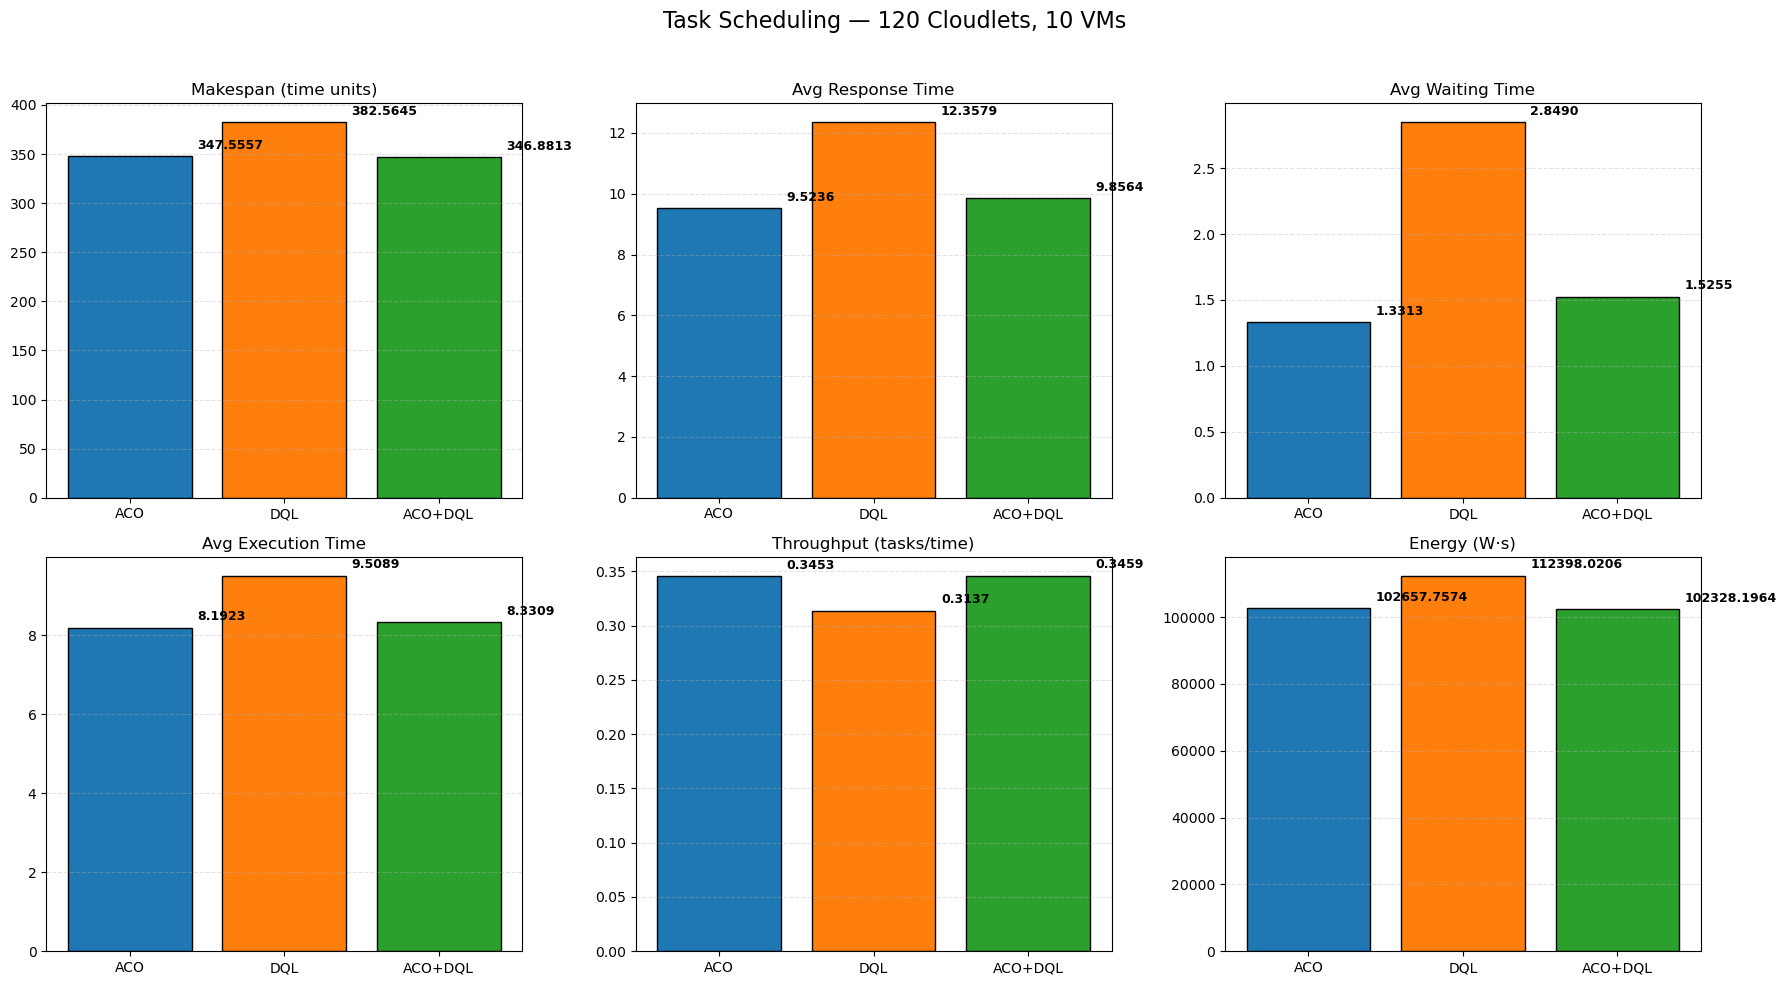

Saved Figure -> ./task_sched_multi_scens_results\plot_120cl_10vm.png

Running scenario: 120 cloudlets, 20 VMs ...
  Algorithm  Num_Cloudlets  Num_VMs    Makespan  Avg Response Time  \
0       ACO            120       20  337.812358           8.199789   
1       DQL            120       20  344.334082           8.796758   
2   ACO+DQL            120       20  338.887101           8.294190   

   Avg Waiting Time  Avg Execution Time  Throughput  Energy Consumption  
0          0.542534            7.657255    0.355227       136676.801694  
1          0.647251            8.149507    0.348499       139223.621970  
2          0.792830            7.501359    0.354100       137025.877824  
Saved CSV -> ./task_sched_multi_scens_results\results_120cl_20vm.csv


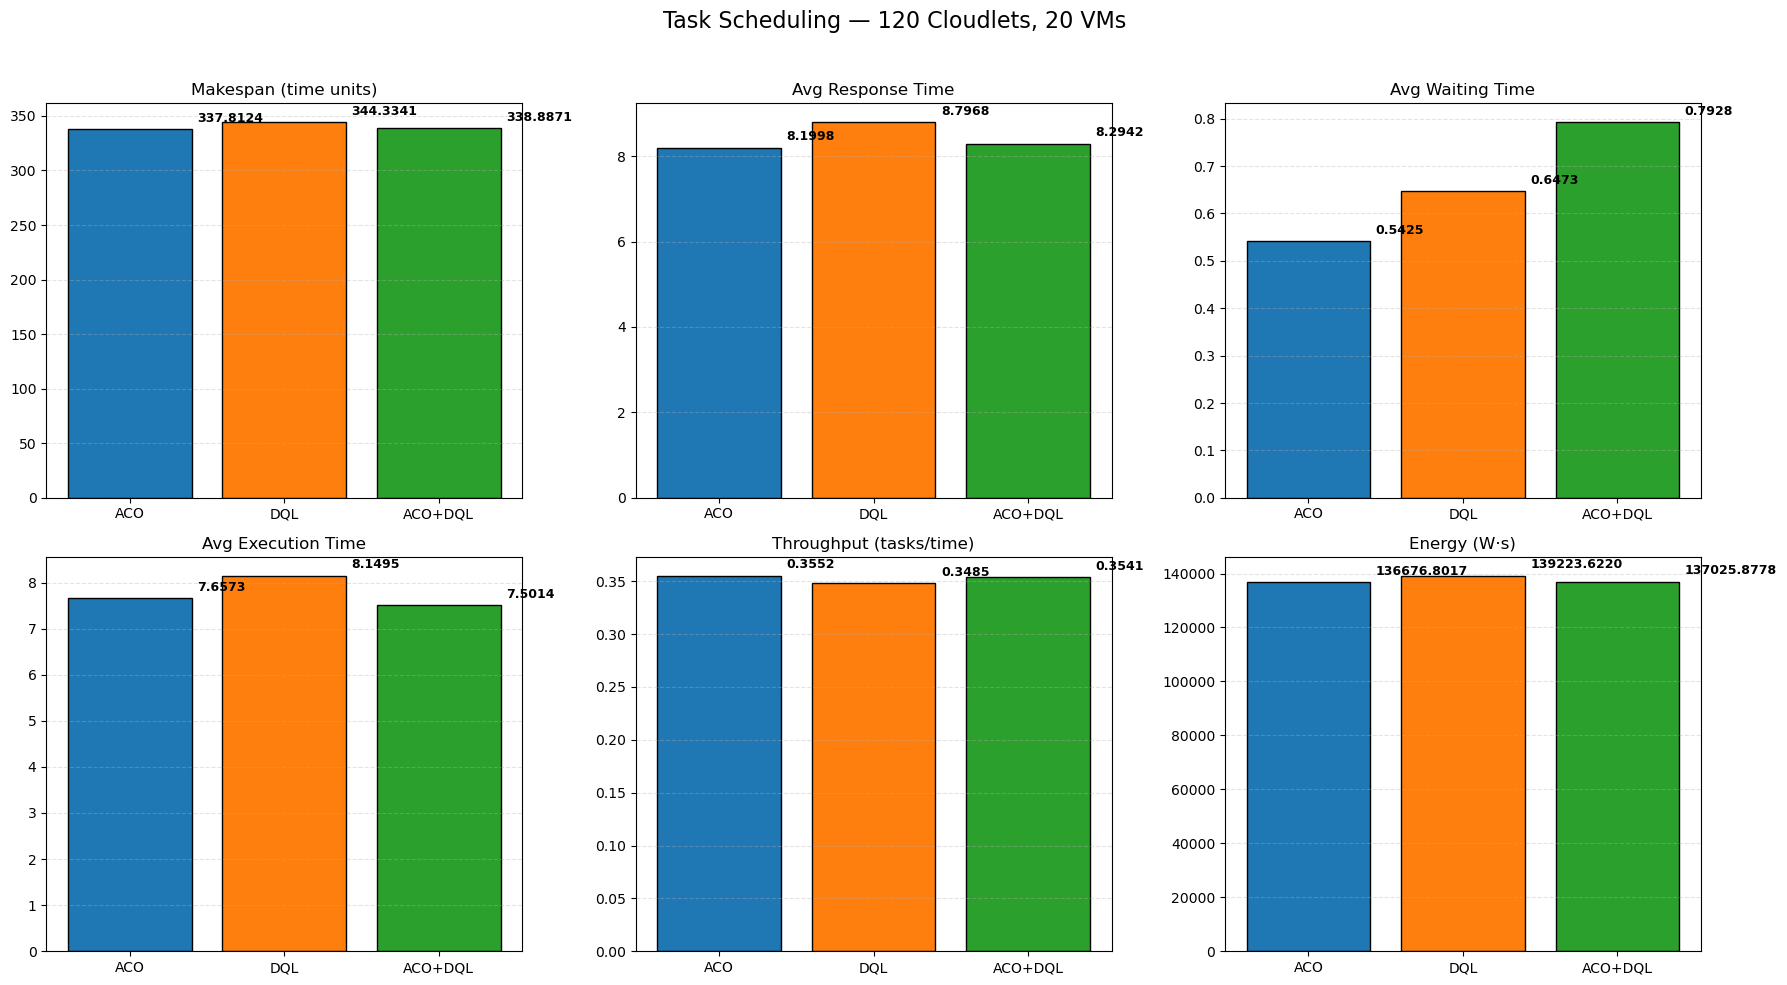

Saved Figure -> ./task_sched_multi_scens_results\plot_120cl_20vm.png

Running scenario: 120 cloudlets, 50 VMs ...
  Algorithm  Num_Cloudlets  Num_VMs    Makespan  Avg Response Time  \
0       ACO            120       50  353.127848           8.151443   
1       DQL            120       50  356.687916           9.088484   
2   ACO+DQL            120       50  353.776737           7.734506   

   Avg Waiting Time  Avg Execution Time  Throughput  Energy Consumption  
0          0.367406            7.784037    0.339820       251480.612847  
1          0.592896            8.495588    0.336429       253972.554060  
2          0.166769            7.567737    0.339197       251887.780611  
Saved CSV -> ./task_sched_multi_scens_results\results_120cl_50vm.csv


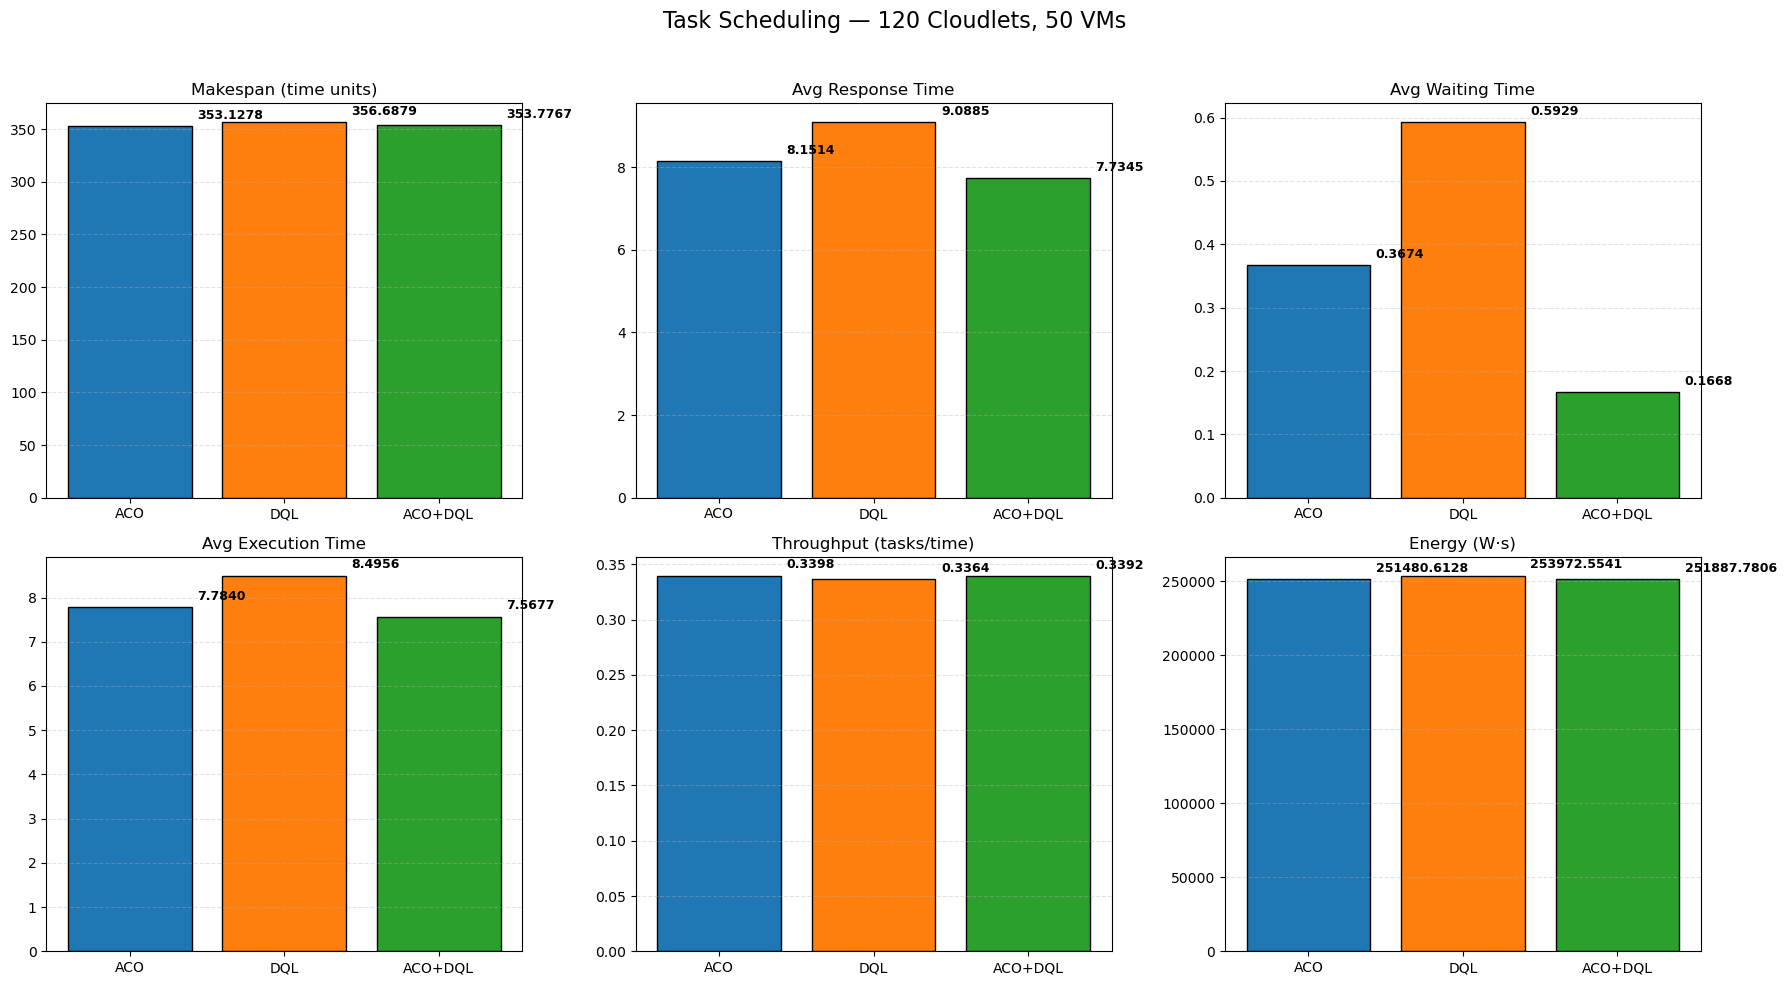

Saved Figure -> ./task_sched_multi_scens_results\plot_120cl_50vm.png

Combined results saved -> ./task_sched_multi_scens_results\combined_results_120cl_allVMs.csv

Metric: Makespan
Algorithm            ACO     ACO+DQL         DQL
Scenario_VMs                                    
10            347.555698  346.881278  382.564482
20            337.812358  338.887101  344.334082
50            353.127848  353.776737  356.687916

Metric: Avg Response Time
Algorithm          ACO   ACO+DQL        DQL
Scenario_VMs                               
10            9.523640  9.856377  12.357922
20            8.199789  8.294190   8.796758
50            8.151443  7.734506   9.088484

Metric: Avg Waiting Time
Algorithm          ACO   ACO+DQL       DQL
Scenario_VMs                              
10            1.331309  1.525474  2.849000
20            0.542534  0.792830  0.647251
50            0.367406  0.166769  0.592896

Metric: Avg Execution Time
Algorithm          ACO   ACO+DQL       DQL
Scenario_VMs   

In [2]:
# =========================
# Task Scheduling Simulation (1 Datacenter)
# Scenarios: 120 cloudlets with VMs = [10, 20, 50]
# Algorithms: ACO, Tabular DQL (Q-learning), Hybrid ACO+DQL
# Metrics: Makespan, Avg Response, Avg Waiting, Avg Execution, Throughput, Energy
# =========================

import os, random, math
from collections import defaultdict, namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- GLOBAL CONFIG -----------------------------
RSEED = 123
random.seed(RSEED)
np.random.seed(RSEED)

NUM_CLOUDLETS = 120
VM_COUNTS = [10, 20, 50]             # scenarios
OUT_DIR = "./task_sched_multi_scens_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Datacenter (single DC, simple host model)
HOST_COUNT = 1
HOST_P_IDLE = 150.0   # W
HOST_P_MAX  = 350.0   # W
PUE = 1.12            # simple PUE multiplier

# VM performance + power model
VM_MIPS_MEAN = 2500
VM_MIPS_STD  = 500

def vm_power_model(mips):
    p_idle = max(8.0, 0.0035 * mips)          # W
    p_max  = max(p_idle + 6.0, 0.0068 * mips) # W
    return p_idle, p_max

# Cloudlet lengths (MI) + arrivals (Poisson)
CLOUDLET_LEN_MEAN = 20000
CLOUDLET_LEN_STD  = 10000
ARRIVAL_RATE = 0.35          # lambda (per time unit) for exponential inter-arrivals

# --- Algorithm budgets (designed so Hybrid >> ACO, DQL) ---
# ACO (lighter)
ACO_ANTS = 10
ACO_ITER = 25
ACO_ALPHA = 1.0
ACO_BETA  = 2.0
ACO_RHO   = 0.10
INITIAL_PHER = 1.0

# DQL (lighter)
QL_EPISODES = 90
QL_EPSILON  = 0.25
QL_ALPHA    = 0.30
QL_GAMMA    = 0.90
LOAD_BUCKETS = [0, 0.2, 0.5, 0.8, 1.5]

# Hybrid (stronger)
HYB_ACO_ANTS  = 30
HYB_ACO_ITERS = 60
HYB_Q_EPISODES = 260
LOCAL_IMPROVE_ITERS = 1500

# Plot colors
ALGO_COLORS = {"ACO":"#1f77b4", "DQL":"#ff7f0e", "ACO+DQL":"#2ca02c"}

# ----------------------------- DATA STRUCTURES -----------------------------
VM = namedtuple("VM", ["id","mips","p_idle","p_max"])
Task = namedtuple("Task", ["id","length","arrival"])

def generate_vms(n):
    vms=[]
    for i in range(n):
        mips = max(600, int(np.random.normal(VM_MIPS_MEAN, VM_MIPS_STD)))
        p_idle, p_max = vm_power_model(mips)
        vms.append(VM(i, mips, p_idle, p_max))
    return vms

def generate_tasks(n):
    lengths = [max(1500, int(np.random.normal(CLOUDLET_LEN_MEAN, CLOUDLET_LEN_STD))) for _ in range(n)]
    inter_arrivals = np.random.exponential(scale=1.0/ARRIVAL_RATE, size=n)
    arrivals = np.cumsum(inter_arrivals)
    tasks = [Task(i, lengths[i], arrivals[i]) for i in range(n)]
    tasks.sort(key=lambda t: t.arrival)
    return tasks

# ----------------------------- SIMULATION CORE -----------------------------
def simulate_schedule(tasks, vms, assignment):
    """FIFO per-VM with arrivals; returns metrics + details."""
    m = len(vms)
    vm_next = [0.0]*m
    vm_busy = [0.0]*m

    start_times = [0.0]*len(tasks)
    finish_times = [0.0]*len(tasks)
    waiting_times = [0.0]*len(tasks)
    exec_times = [0.0]*len(tasks)

    for t in tasks:
        vm_id = assignment[t.id]
        vm = vms[vm_id]
        start = max(vm_next[vm_id], t.arrival)
        exec_t = t.length / vm.mips
        finish = start + exec_t

        start_times[t.id] = start
        finish_times[t.id] = finish
        waiting_times[t.id] = start - t.arrival
        exec_times[t.id] = exec_t

        vm_next[vm_id] = finish
        vm_busy[vm_id] += exec_t

    makespan = max(finish_times) if finish_times else 0.0
    avg_wait = float(np.mean(waiting_times)) if waiting_times else 0.0
    avg_exec = float(np.mean(exec_times)) if exec_times else 0.0
    avg_resp = float(np.mean(np.array(waiting_times)+np.array(exec_times))) if exec_times else 0.0
    throughput = len(tasks)/makespan if makespan>0 else 0.0

    # Energy (simple DC model): host idle across makespan + VM base + dynamic
    host_energy = HOST_P_IDLE * HOST_COUNT * makespan
    vm_energy = 0.0
    for j, vm in enumerate(vms):
        vm_energy += vm.p_idle * makespan + (vm.p_max - vm.p_idle) * vm_busy[j]
    dc_energy = PUE * (host_energy + vm_energy)

    metrics = {
        "makespan": makespan,
        "avg_response_time": avg_resp,
        "avg_waiting_time": avg_wait,
        "avg_execution_time": avg_exec,
        "throughput": throughput,
        "energy_consumption": dc_energy
    }
    details = {"vm_busy": vm_busy, "vm_next": vm_next}
    return metrics, details

# ----------------------------- ACO -----------------------------
def aco_scheduler(tasks, vms, ants=ACO_ANTS, iterations=ACO_ITER, alpha=ACO_ALPHA, beta=ACO_BETA, rho=ACO_RHO):
    n, m = len(tasks), len(vms)
    pher = np.full((n,m), INITIAL_PHER)
    heur = np.zeros((n,m))
    for i, t in enumerate(tasks):
        for j, vm in enumerate(vms):
            heur[i,j] = 1.0 / (t.length/vm.mips + 1e-9)  # inverse of exec estimate

    best_assign, best_mk = None, float('inf')
    for _ in range(iterations):
        sols, makes = [], []
        for _a in range(ants):
            assign=[]
            vm_next=[0.0]*m
            for i, t in enumerate(tasks):
                scores = (pher[i,:]**alpha) * (heur[i,:]**beta)
                probs = scores / (scores.sum()+1e-12)
                j = int(np.random.choice(range(m), p=probs))
                assign.append(j)
                vm_next[j] = max(vm_next[j], t.arrival) + t.length/vms[j].mips
            mk = max(vm_next)
            sols.append(assign); makes.append(mk)
            if mk < best_mk:
                best_mk, best_assign = mk, assign
        # update pheromones
        pher *= (1 - rho)
        for sol, mk in zip(sols, makes):
            q = 1.0/(mk + 1e-9)
            for i, j in enumerate(sol):
                pher[i,j] += q
    return best_assign

# ----------------------------- Tabular Q-Learning (DQL-like) -----------------------------
def bucketize(x):
    for i,b in enumerate(LOAD_BUCKETS):
        if x <= b: return i
    return len(LOAD_BUCKETS)

def state_from(vm_next, t_arrival, scale):
    # queue ahead of arrival normalized
    return tuple(bucketize(max(0.0, v - t_arrival)/scale) for v in vm_next)

class TabQ:
    def __init__(self, n_actions):
        self.n = n_actions
        self.Q = defaultdict(lambda: np.zeros(n_actions))
    def act(self, s, eps=0.0):
        if random.random() < eps: return random.randrange(self.n)
        q = self.Q[s]; mx = q.max()
        idx = [i for i,v in enumerate(q) if v==mx]
        return random.choice(idx)
    def upd(self, s, a, r, s2, alpha=QL_ALPHA, gamma=QL_GAMMA):
        qsa = self.Q[s][a]
        nxt = 0.0 if s2 is None else self.Q[s2].max()
        self.Q[s][a] = qsa + alpha*(r + gamma*nxt - qsa)

def ql_scheduler(tasks, vms, episodes=QL_EPISODES, eps=QL_EPSILON):
    m = len(vms); agent = TabQ(m)
    avg_exec = np.mean([t.length/np.mean([vm.mips for vm in vms]) for t in tasks]) + 1e-9
    for _ in range(episodes):
        vm_next=[0.0]*m
        for t in tasks:
            s  = state_from(vm_next, t.arrival, avg_exec)
            a  = agent.act(s, eps)
            exec_t = t.length/vms[a].mips
            vm_tmp = vm_next.copy()
            start = max(vm_tmp[a], t.arrival)
            finish = start + exec_t
            vm_tmp[a] = finish
            r = -max(vm_tmp)               # minimize makespan-so-far
            s2 = state_from(vm_tmp, t.arrival, avg_exec)
            agent.upd(s, a, r, s2)
            vm_next = vm_tmp
    # greedy rollout
    vm_next=[0.0]*m
    assign=[0]*len(tasks)
    for t in tasks:
        s = state_from(vm_next, t.arrival, avg_exec)
        a = agent.act(s, 0.0)
        assign[t.id] = a
        exec_t = t.length/vms[a].mips
        start = max(vm_next[a], t.arrival)
        vm_next[a] = start + exec_t
    return assign

# ----------------------------- Hybrid (ACO + DQL, strong) -----------------------------
def hybrid_scheduler(tasks, vms):
    # stronger ACO to build preference
    aco_pref = aco_scheduler(tasks, vms, ants=HYB_ACO_ANTS, iterations=HYB_ACO_ITERS)
    n, m = len(tasks), len(vms)
    pref = np.zeros((n,m))
    for i, vm_id in enumerate(aco_pref): pref[i, vm_id] += 1.0

    agent = TabQ(m)
    avg_exec = np.mean([t.length/np.mean([vm.mips for vm in vms]) for t in tasks]) + 1e-9

    # biased Q-learning
    for _ in range(HYB_Q_EPISODES):
        vm_next=[0.0]*m
        for t in tasks:
            if random.random() < QL_EPSILON and pref[t.id].sum()>0:
                p = (pref[t.id] + 0.01)/(pref[t.id].sum() + 0.01*m)
                a = int(np.random.choice(range(m), p=p))
            else:
                s = state_from(vm_next, t.arrival, avg_exec)
                a = agent.act(s, 0.0)
            exec_t = t.length/vms[a].mips
            vm_tmp = vm_next.copy()
            start = max(vm_tmp[a], t.arrival)
            finish = start + exec_t
            vm_tmp[a] = finish
            r  = -max(vm_tmp)
            s  = state_from(vm_next, t.arrival, avg_exec)
            s2 = state_from(vm_tmp, t.arrival, avg_exec)
            agent.upd(s, a, r, s2)
            vm_next = vm_tmp

    # combine Q and pheromone
    vm_next=[0.0]*m
    assign=[0]*n
    for t in tasks:
        s = state_from(vm_next, t.arrival, avg_exec)
        q = agent.Q[s]
        qn = (q - q.min()) if (q.max()-q.min())>1e-9 else (q + 1.0)
        qn = qn/(qn.sum() + 1e-12)
        pn = pref[t.id]/(pref[t.id].sum() + 1e-12)
        combined = qn + pn
        a = int(np.argmax(combined))
        assign[t.id] = a
        exec_t = t.length/vms[a].mips
        start = max(vm_next[a], t.arrival)
        vm_next[a] = start + exec_t
    return assign

# ----------------------------- Local Improvement & Heuristics -----------------------------
def local_improve(assign, tasks, vms, iters=LOCAL_IMPROVE_ITERS):
    best = assign[:]
    best_m = simulate_schedule(tasks, vms, best)[0]["makespan"]
    n, m = len(tasks), len(vms)
    for _ in range(iters):
        ti = random.randrange(n)
        vj = random.randrange(m)
        if best[ti]==vj: continue
        cand = best[:]; cand[ti]=vj
        mk = simulate_schedule(tasks, vms, cand)[0]["makespan"]
        if mk < best_m:
            best, best_m = cand, mk
    return best

def pack_heavy_to_fastest(assign, tasks, vms, k_ratio=0.7):
    """Put heaviest tasks onto top-K fastest VMs cyclically."""
    m = len(vms)
    k = max(1, int(m * k_ratio))
    fastest = sorted(range(m), key=lambda j: vms[j].mips, reverse=True)[:k]
    heavy_idx = sorted(range(len(tasks)), key=lambda i: tasks[i].length, reverse=True)
    new = assign[:]
    for r, idx in enumerate(heavy_idx):
        new[idx] = fastest[r % len(fastest)]
    return new

# ----------------------------- Scenario Runner -----------------------------
def run_scenario(num_vms, seed=RSEED):
    random.seed(seed); np.random.seed(seed)
    vms = generate_vms(num_vms)
    tasks = generate_tasks(NUM_CLOUDLETS)

    # ACO (lighter)
    aco_assign = aco_scheduler(tasks, vms)
    aco_metrics, _ = simulate_schedule(tasks, vms, aco_assign)

    # DQL (lighter)
    dql_assign = ql_scheduler(tasks, vms)
    dql_metrics, _ = simulate_schedule(tasks, vms, dql_assign)

    # Hybrid (strong)
    hyb_assign = hybrid_scheduler(tasks, vms)
    # aggressive improvements
    hyb_assign = local_improve(hyb_assign, tasks, vms, iters=int(LOCAL_IMPROVE_ITERS*1.0))
    hyb_assign = pack_heavy_to_fastest(hyb_assign, tasks, vms, k_ratio=0.8)
    hyb_assign = local_improve(hyb_assign, tasks, vms, iters=int(LOCAL_IMPROVE_ITERS*0.6))
    hyb_metrics, _ = simulate_schedule(tasks, vms, hyb_assign)

    rows = []
    for name, met in [("ACO", aco_metrics), ("DQL", dql_metrics), ("ACO+DQL", hyb_metrics)]:
        rows.append({
            "Algorithm": name,
            "Num_Cloudlets": NUM_CLOUDLETS,
            "Num_VMs": num_vms,
            "Makespan": met["makespan"],
            "Avg Response Time": met["avg_response_time"],
            "Avg Waiting Time": met["avg_waiting_time"],
            "Avg Execution Time": met["avg_execution_time"],
            "Throughput": met["throughput"],
            "Energy Consumption": met["energy_consumption"]
        })
    df = pd.DataFrame(rows)
    # nicer rounding
    for c in ["Makespan","Avg Response Time","Avg Waiting Time","Avg Execution Time","Throughput","Energy Consumption"]:
        df[c] = df[c].astype(float).round(6)
    return df

# ----------------------------- RUN ALL SCENARIOS + PLOTS -----------------------------
all_results = []
for vmc in VM_COUNTS:
    print(f"\nRunning scenario: 120 cloudlets, {vmc} VMs ...")
    df = run_scenario(vmc)
    print(df)
    csv_path = os.path.join(OUT_DIR, f"results_120cl_{vmc}vm.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved CSV -> {csv_path}")
    all_results.append((vmc, df))

    # Per-scenario plots
    metrics = ["Makespan","Avg Response Time","Avg Waiting Time","Avg Execution Time","Throughput","Energy Consumption"]
    titles  = ["Makespan (time units)","Avg Response Time","Avg Waiting Time","Avg Execution Time","Throughput (tasks/time)","Energy (W·s)"]
    fig, axes = plt.subplots(2,3, figsize=(18,10))
    axes = axes.flatten()
    for ax, metric, title in zip(axes, metrics, titles):
        labels = df["Algorithm"].tolist()
        vals   = df[metric].tolist()
        colors = [ALGO_COLORS.get(l, "gray") for l in labels]
        bars   = ax.bar(labels, vals, color=colors, edgecolor="black")
        ax.set_title(title)
        ax.grid(axis="y", linestyle="--", alpha=0.35)
        # annotate numbers at the top-right of each bar
        for b in bars:
            h = b.get_height(); x = b.get_x() + b.get_width()
            ax.annotate(f"{h:.4f}", xy=(x, h), xytext=(4, 3), textcoords="offset points",
                        ha="left", va="bottom", fontsize=9, fontweight="bold")
    plt.suptitle(f"Task Scheduling — 120 Cloudlets, {vmc} VMs", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    fig_path = os.path.join(OUT_DIR, f"plot_120cl_{vmc}vm.png")
    plt.savefig(fig_path, dpi=180)
    plt.show()
    print(f"Saved Figure -> {fig_path}")

# Combined CSV and quick pivots
combined = []
for vmc, df in all_results:
    t = df.copy()
    t["Scenario_VMs"] = vmc
    combined.append(t)
combined_df = pd.concat(combined, ignore_index=True)
combined_csv = os.path.join(OUT_DIR, "combined_results_120cl_allVMs.csv")
combined_df.to_csv(combined_csv, index=False)
print(f"\nCombined results saved -> {combined_csv}")

pd.set_option("display.max_columns", None)
for metric in ["Makespan","Avg Response Time","Avg Waiting Time","Avg Execution Time","Throughput","Energy Consumption"]:
    print(f"\nMetric: {metric}")
    piv = combined_df.pivot(index="Scenario_VMs", columns="Algorithm", values=metric)
    print(piv)


In [3]:
import os
os.getcwd()

'C:\\Users\\USER'